---
title: Main Experiments
execute:
  freeze: true
---

# Imports

In [74]:
import pickle as pkl
from collections import defaultdict
from concurrent.futures import ProcessPoolExecutor, as_completed

import h5py
import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import scipy.io as sio
from scipy.signal import (butter, coherence, correlate, filtfilt, resample,
                          sosfiltfilt, welch)
from scipy.stats import ttest_1samp
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.svm import SVC

# Loading experiment data

In [75]:
trial = 'A2'
eeg_filepath = f'../data/{trial}/converted/eeg_matrix.mat'
eeg_trialinfo = f'../data/{trial}/converted/trialinfo_matrix_{trial}_cleanedtrials.mat'
eeg_raw_data = f'../data/{trial}/experimental/data.mat'
eeg_labels_path = f'../data/A0/preprocessing/channel_labels.mat' # always get the labels from A0


In [76]:
f = sio.loadmat(eeg_labels_path)
labels = f['channellabels_ADSselection']
len(labels) # 37 + 4

41

In [77]:
def load_mat_file(filepath):
    """ Load a MATLAB .mat file and return its content. """
    try:
        mat_contents = sio.loadmat(filepath)
        return mat_contents
    except NotImplementedError:
        # If the file is v7.3, it will need h5py to handle it
        with h5py.File(filepath, 'r') as file:
            return {key: np.array(value) for key, value in file.items()}

def get_eeg_data(eeg_data_path):
    """ Extract EEG data from the .mat file. """
    data = load_mat_file(eeg_data_path)
    eeg_data = data['data_eeg']
    return eeg_data

def get_trial_info(trial_info_path):
    """ Extract trial information from the .mat file. """
    data = load_mat_file(trial_info_path)
    trial_info = data['all_info']
    return trial_info

def load_raw_data(noise_data_path):
    """ Load and return the entire noise stimuli structure from the .mat file. """
    mat_contents = load_mat_file(noise_data_path)
    # Extract the 'noise_stims' from the nested structure
    noise_stims = mat_contents['data'][0, 0]
    return noise_stims

def get_specific_raw_data(idx, eeg_raw_data, block_index, trial_index):
    """ Fetch the specific noise stimulus for the given block, trial, and channel (0 for left, 1 for right). """
    idxs = ['reaction_times', 'reaction_err', 'answers', 'base_delay', 'target_timings', 'flicker_sides', 'attend_sides', 'orients_L', 'orients_R', 'angle_magnitude', 'probe_sides', 'missed', 'targets_binary', 'tagging_types', 'noise_stims', 'p_num', 'date']
    return eeg_raw_data[idxs.index(idx)][block_index, trial_index]

def trial_number_to_indices(trial_number):
    """ Convert trial number to block and trial indices, zero-indexed. """
    trial_number = int(trial_number) - 1
    block_index = trial_number // 32 + 1 # +1 block because we've discard the first block
    trial_index = trial_number  % 32
    return block_index, trial_index

def load_and_process_data(eeg_filepath, trialinfo_filepath, raw_data_filepath):
    eeg_data = get_eeg_data(eeg_filepath)
    trial_info = get_trial_info(trialinfo_filepath)
    eeg_raw_data = load_raw_data(raw_data_filepath)

    processed_trials = []
    # Assuming we loop over actual trial data, adjust as necessary
    for trial, eeg_data in zip(trial_info, eeg_data):
        block_index, trial_index = trial_number_to_indices(trial[14])

        # Access the corresponding noise stimulus for left and right channels
        noise_stim_left, noise_stim_right = get_specific_raw_data('noise_stims', eeg_raw_data, block_index, trial_index)

        trial_data = {
            'eeg': eeg_data,  # Adjust for zero-index and skip block 1
            'trial_info': trial,
            'reaction_time_1': trial[2],
            'reaction_time_2': get_specific_raw_data('reaction_times', eeg_raw_data, block_index, trial_index),
            'has_noise': bool(int(trial[13])),
            'has_56|64': int(trial[7]) == 0,
            'has_56|60': int(trial[7]) == 1,
            'attended_side': trial[8],
            'noise_stim_left': noise_stim_left,
            'noise_stim_right': noise_stim_right,
            'base_delay': trial[6],
            'target_timings': trial[5],
        }
        processed_trials.append(trial_data)

    return processed_trials

experiment_data = load_and_process_data(eeg_filepath, eeg_trialinfo, eeg_raw_data)
experiment_data = pd.DataFrame(experiment_data)
# These are in the form trials (440), samples (6758), channels (37)
eeg_data = np.stack(experiment_data['eeg'])
channel_labels = load_mat_file(eeg_labels_path)['channellabels_ADSselection'].flatten()
channel_labels = [x[0] for x in channel_labels][:-4] # remove the last 4 channels, they're not used (EXG1 EXG2 EXG3 EXG4)
print(' '.join(channel_labels))

Fp1 AF7 AF3 F1 F3 F5 F7 FT7 FC5 FC3 FC1 C1 C3 C5 T7 TP7 CP5 CP3 CP1 P1 P3 P5 P7 PO7 PO3 O1 Iz Oz POz Pz P2 P4 P6 P8 PO8 PO4 O2


# Functions to calculate cross correlation of noise over a trial

0.246
0.7689999999999999
(6758, 37)
(4800,)
6553 4403 6553


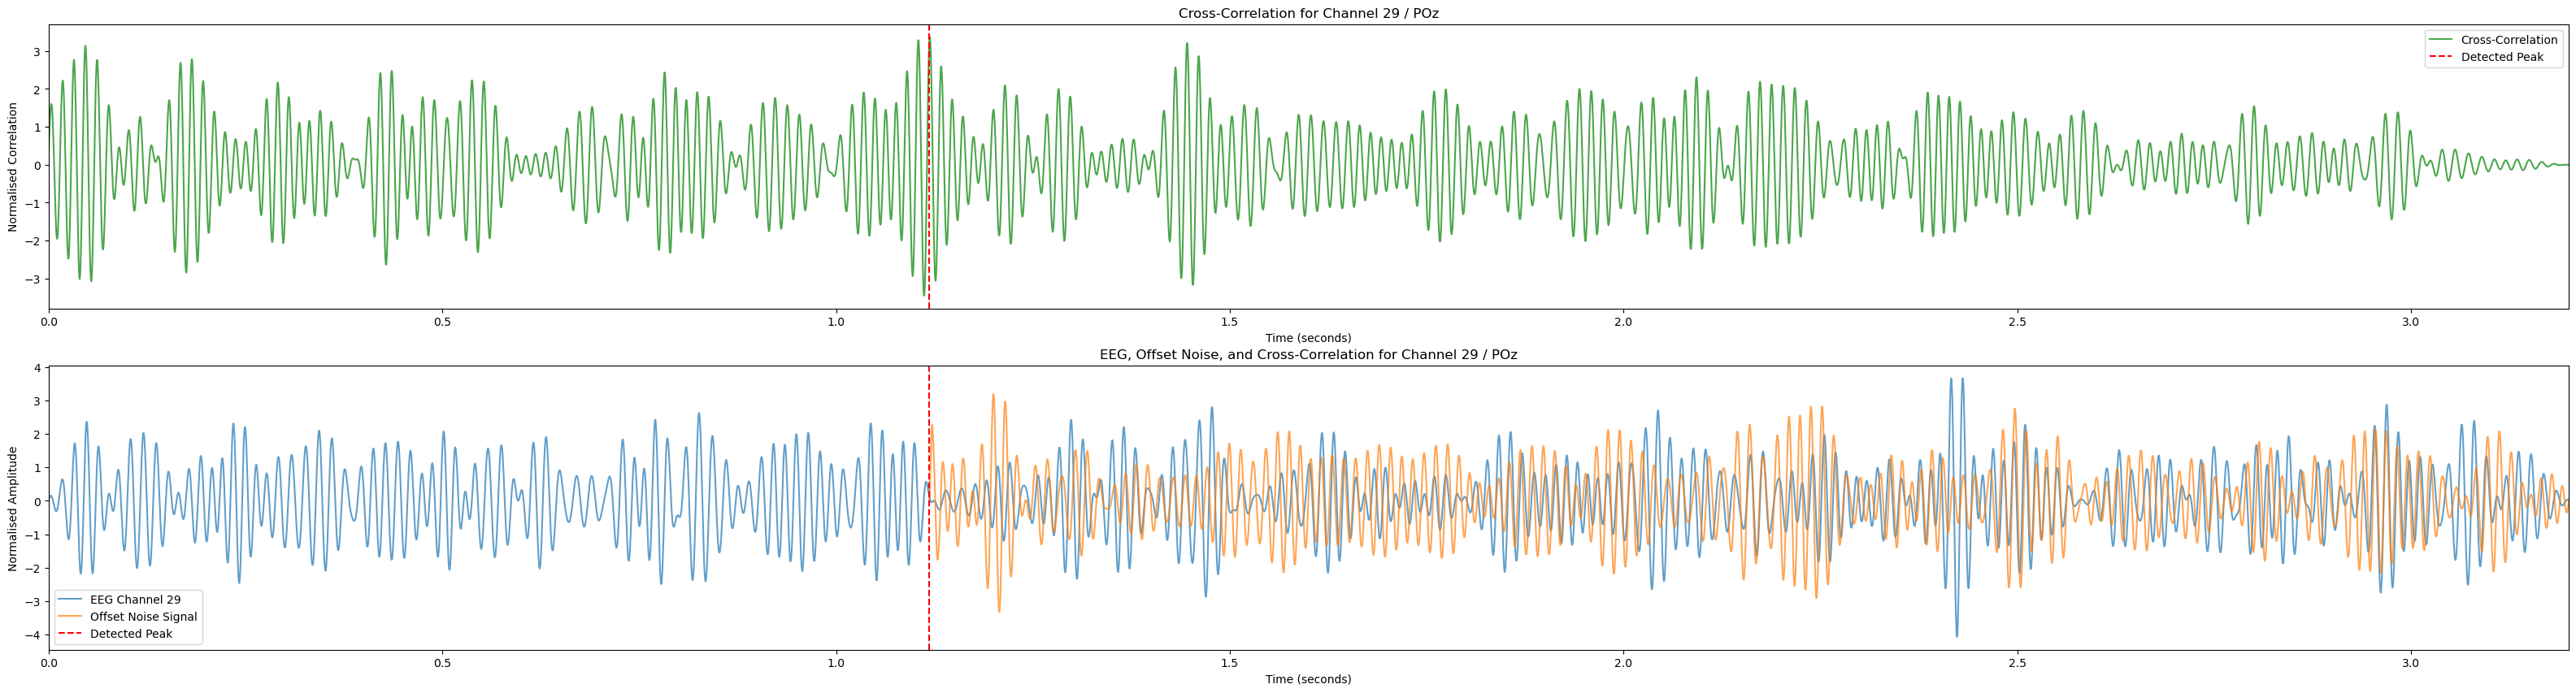

Lags: [np.int64(508), np.int64(2330), np.int64(1076), np.int64(1112), np.int64(1740), np.int64(3208), np.int64(2569), np.int64(142), np.int64(873), np.int64(801), np.int64(2100), np.int64(1247), np.int64(2629), np.int64(873), np.int64(1429), np.int64(1645), np.int64(1463), np.int64(902), np.int64(2628), np.int64(189), np.int64(728), np.int64(1216), np.int64(1462), np.int64(439), np.int64(409), np.int64(1349), np.int64(301), np.int64(1004), np.int64(2291), np.int64(407), np.int64(406), np.int64(403), np.int64(2538), np.int64(1116), np.int64(747), np.int64(2535), np.int64(715)]


In [78]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def butter_bandpass_sos(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    sos = butter(order, [low, high], btype='band', output='sos')
    return sos

def bandpass_filter_sos(data, lowcut, highcut, fs, order=5):
    sos = butter_bandpass_sos(lowcut, highcut, fs, order=order)
    y = sosfiltfilt(sos, data)
    return y

def mix_signals(eeg_data, noise_signal, strength):
    mixed_data = (1-strength) * eeg_data + strength * noise_signal
    return mixed_data

def upsample_or_downsample(data, original_freq, new_freq):
    """ Upsample or downsample data to the new frequency. """
    num_samples = int(len(data) * new_freq / original_freq)
    return resample(data, num_samples)

def normalise_signal(signal):
    return (signal - np.mean(signal)) / np.std(signal)

def compute_best_combined_offset(eeg_data, noise_stim_left, noise_stim_right, channel_labels,
                                 sampling_rate=2048, noise_freq=480,
                                 upsample_noise=True, eeg_start_time=0.0, eeg_end_time=3.2,
                                 noise_start_time=0.0, noise_end_time=2.15,
                                 bandpass_eeg=None, bandpass_noise=None, mix_noise_strength=None, plot_results=False):

    num_samples, num_channels = eeg_data.shape
    # num_channels = len(channel_labels)
    eeg_segment_start = int(eeg_start_time * sampling_rate)
    eeg_segment_end = int(eeg_end_time * sampling_rate)

    # Select EEG segment
    eeg_data_segment = eeg_data[eeg_segment_start:eeg_segment_end, :].copy()

    # Select noise segment
    noise_segment_start = int(noise_start_time * noise_freq)
    noise_segment_end = int(noise_end_time * noise_freq)
    noise_stim_left_segment = noise_stim_left[noise_segment_start:noise_segment_end].copy()
    noise_stim_right_segment = noise_stim_right[noise_segment_start:noise_segment_end].copy()

    # Optionally bandpass filter the signals
    if bandpass_eeg:
        lowcut, highcut = bandpass_eeg
        for channel in range(num_channels):
            eeg_data_segment[:, channel] = bandpass_filter_sos(eeg_data_segment[:, channel], lowcut, highcut, sampling_rate)

    if bandpass_noise:
        lowcut, highcut = bandpass_noise
        noise_stim_left_segment = bandpass_filter_sos(noise_stim_left_segment, lowcut, highcut, noise_freq)
        noise_stim_right_segment = bandpass_filter_sos(noise_stim_right_segment, lowcut, highcut, noise_freq)

    # Upsample or downsample the noise signals
    if upsample_noise:
        noise_stim_left_segment = upsample_or_downsample(noise_stim_left_segment, noise_freq, sampling_rate)
        noise_stim_right_segment = upsample_or_downsample(noise_stim_right_segment, noise_freq, sampling_rate)
    else:
        eeg_data_segment = upsample_or_downsample(eeg_data_segment, sampling_rate, noise_freq)
        sampling_rate = noise_freq

    # Normalise the signals before mixing and cross-correlation
    noise_stim_left_segment = normalise_signal(noise_stim_left_segment)
    noise_stim_right_segment = normalise_signal(noise_stim_right_segment)
    eeg_data_segment = normalise_signal(eeg_data_segment)

    # Optionally merge the noise signals
    mixed_noise_signal = (noise_stim_left_segment + noise_stim_right_segment) / 2

    # Optionally mix the noise signal into the EEG data
    if mix_noise_strength is not None:
        offset = 1 * sampling_rate
        for channel in range(num_channels):
            eeg_data_segment[offset:offset+len(mixed_noise_signal), channel] = mix_signals(eeg_data_segment[offset:offset+len(mixed_noise_signal), channel], mixed_noise_signal, mix_noise_strength)

    # Store the cross-correlation results and lags
    cross_corr_results = []
    lags = []
    max_cors = []

    for channel, channel_label in zip(range(num_channels), channel_labels):
        eeg_channel_data = eeg_data_segment[:, channel]

        # Compute cross-correlation with the mixed noise signal
        corr = correlate(eeg_channel_data, mixed_noise_signal, mode='full')[len(mixed_noise_signal) - 1:
                                                                            len(mixed_noise_signal) - 1 + len(eeg_channel_data)]
        # Above aligns corr, so that the measured lag corresponds directly to where the signal starts in the EEG data

        # Find the peak in the cross-correlation
        peak_lag = np.argmax(corr)
        # Store results
        cross_corr_results.append(corr)
        lags.append(peak_lag)
        max_cors.append(np.max(corr))

    if not plot_results:
        return lags, cross_corr_results

    # Plotting the results
    pkl.dump({
        'lags': lags,
        'cross_corr_results': cross_corr_results,
        'mixed_noise_signal': mixed_noise_signal,
        'eeg_data_segment': eeg_data_segment,
        'channel_labels': channel_labels,
        'num_channels': num_channels,
    }, open(f'../data/plot_data/cross_corr_results_{trial}.pkl', 'wb'))

    time_vector = np.linspace(eeg_start_time, eeg_end_time, eeg_data_segment.shape[0])
    for channel in range(num_channels):
        if channel_labels[channel] != 'POz': continue
        plt.figure(figsize=(40, 10))  # Adjusting the figure size for better visualization

        normalised_eeg = normalise_signal(eeg_data_segment[:, channel])
        normalised_noise = normalise_signal(mixed_noise_signal)
        normalised_corr = normalise_signal(cross_corr_results[channel])

        print(len(normalised_eeg), len(normalised_noise), len(normalised_corr))

        peak_time = lags[channel] / sampling_rate
        offset_time_vector = np.linspace(0, len(normalised_noise) / sampling_rate, len(normalised_noise)) + peak_time

        # Plot cross-correlation in the upper subplot
        ax1 = plt.subplot(2, 1, 1)
        plt.plot(time_vector, normalised_corr, color='g', label='Cross-Correlation', alpha=0.7, linestyle='-')
        plt.axvline(x=peak_time, color='r', linestyle='--', label='Detected Peak')
        plt.legend()
        plt.title(f'Cross-Correlation for Channel {channel + 1} / {channel_labels[channel]}')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Normalised Correlation')
        plt.xlim(eeg_start_time, eeg_end_time)

        # Plot EEG and noise signals in the lower subplot
        ax2 = plt.subplot(2, 1, 2)
        plt.plot(time_vector, normalised_eeg, label=f'EEG Channel {channel + 1}', alpha=0.7)
        plt.plot(offset_time_vector, normalised_noise, label='Offset Noise Signal', alpha=0.7)
        plt.axvline(x=peak_time, color='r', linestyle='--', label='Detected Peak')
        plt.legend()
        plt.title(f'EEG, Offset Noise, and Cross-Correlation for Channel {channel + 1} / {channel_labels[channel]}')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Normalised Amplitude')
        plt.xlim(eeg_start_time, eeg_end_time)

        plt.show()

    return lags, cross_corr_results

noise_experiments = experiment_data[experiment_data['has_noise']]
skip = 16
for _, experiment in noise_experiments.iterrows():
    if skip > 0:
        skip -= 1
        continue
    eeg_data = experiment['eeg']
    print(experiment['base_delay'])
    print(experiment['target_timings'])
    print(eeg_data.shape)
    noise_stim_left = experiment['noise_stim_left']
    noise_stim_right = experiment['noise_stim_right']
    print(noise_stim_left.shape)

    lags, _ = compute_best_combined_offset(eeg_data, noise_stim_left, noise_stim_right, channel_labels,
                                        upsample_noise=True,
                                        eeg_start_time=0.0, eeg_end_time=3.2,
                                        noise_start_time=0.0, noise_end_time=2.15, # noise times present in the experiment
                                        bandpass_eeg=(50, 80), bandpass_noise=(50, 80),
                                        mix_noise_strength=0, # this can be used to mix in noise
                                        plot_results=True
    )
    print('Lags:', lags)
    break

# Visualise cross correlation over all trials

In [79]:
eeg_data.shape

(6758, 37)

(233, 12)


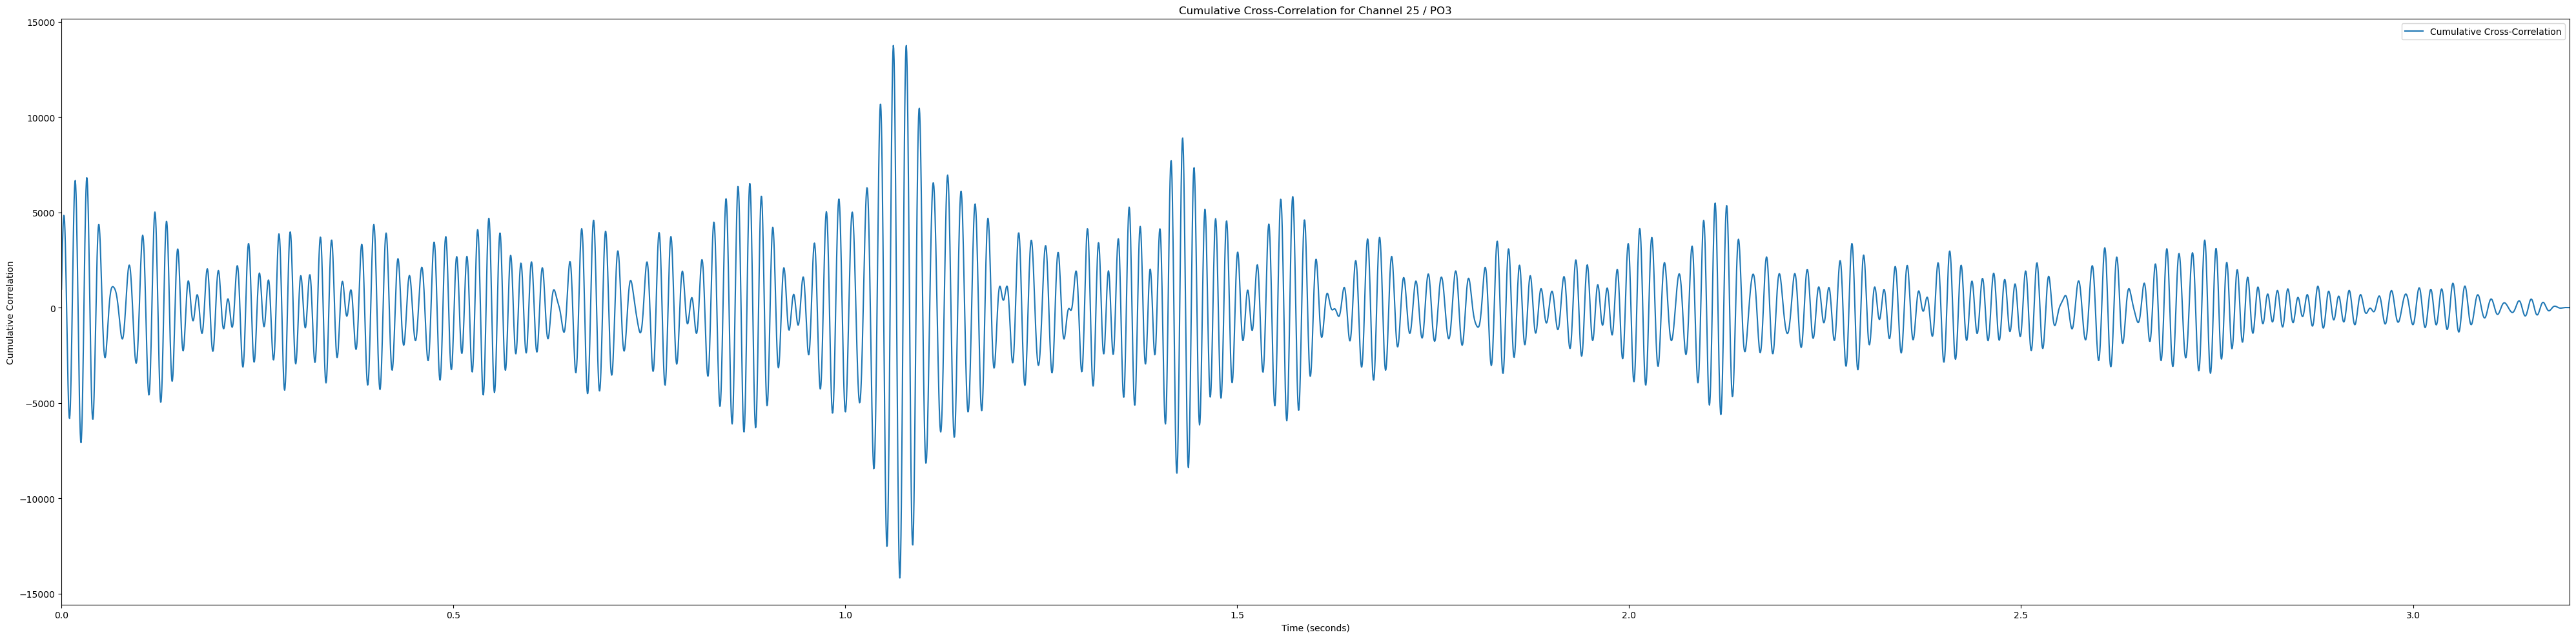

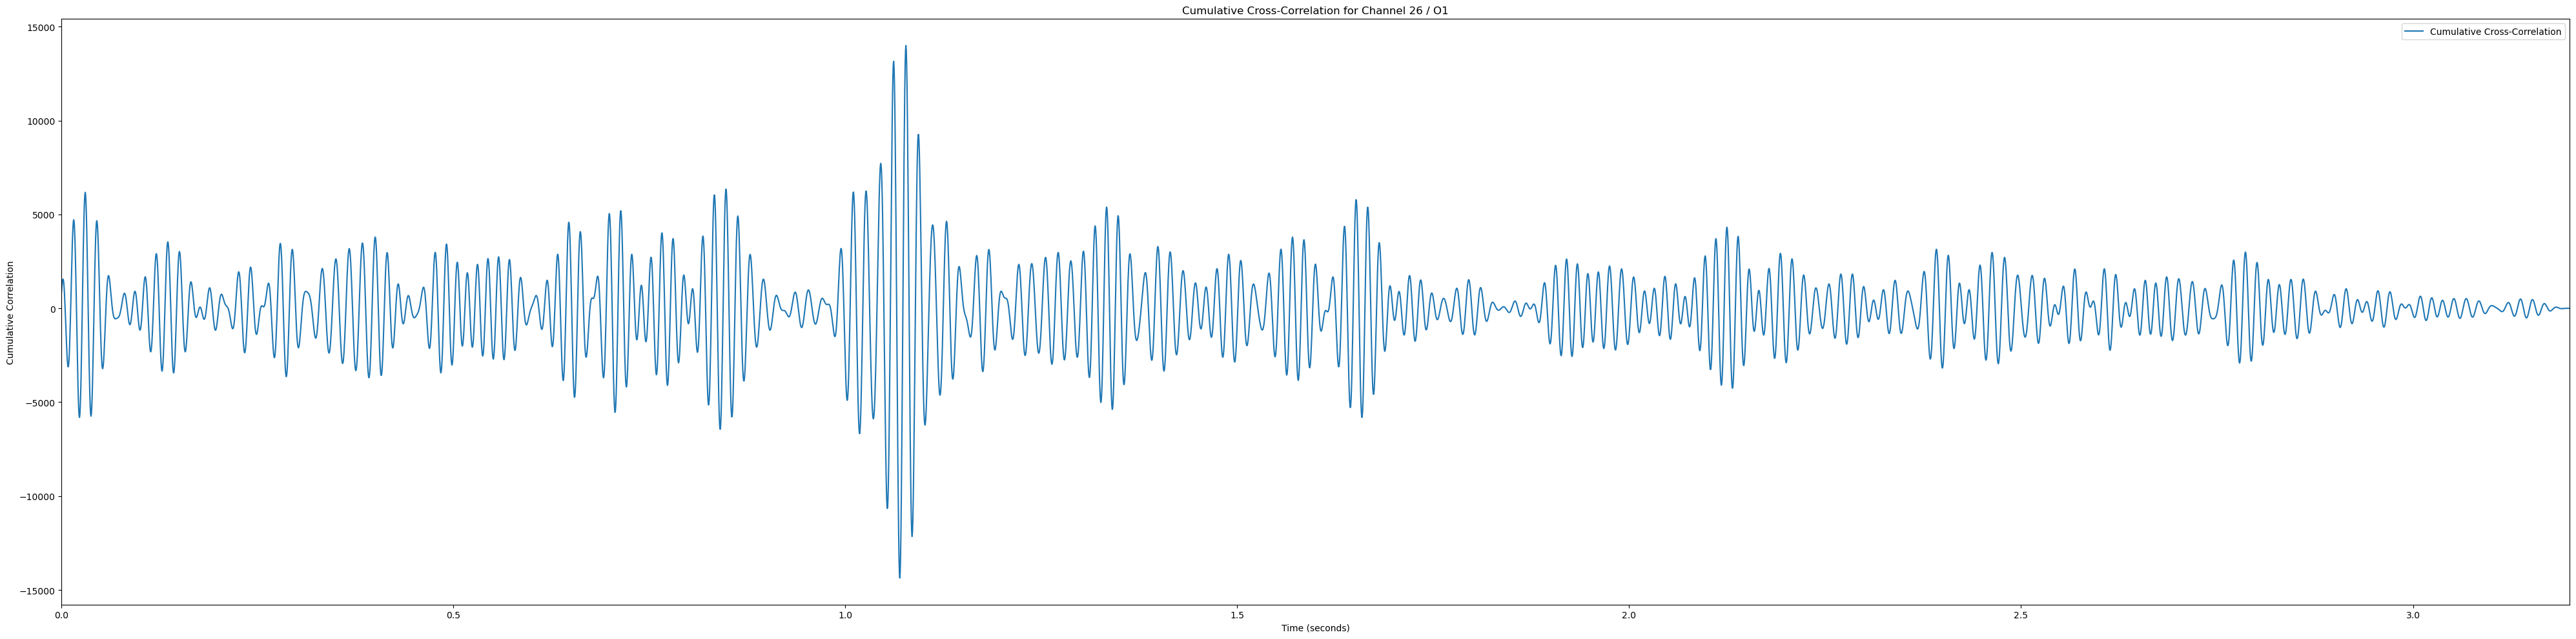

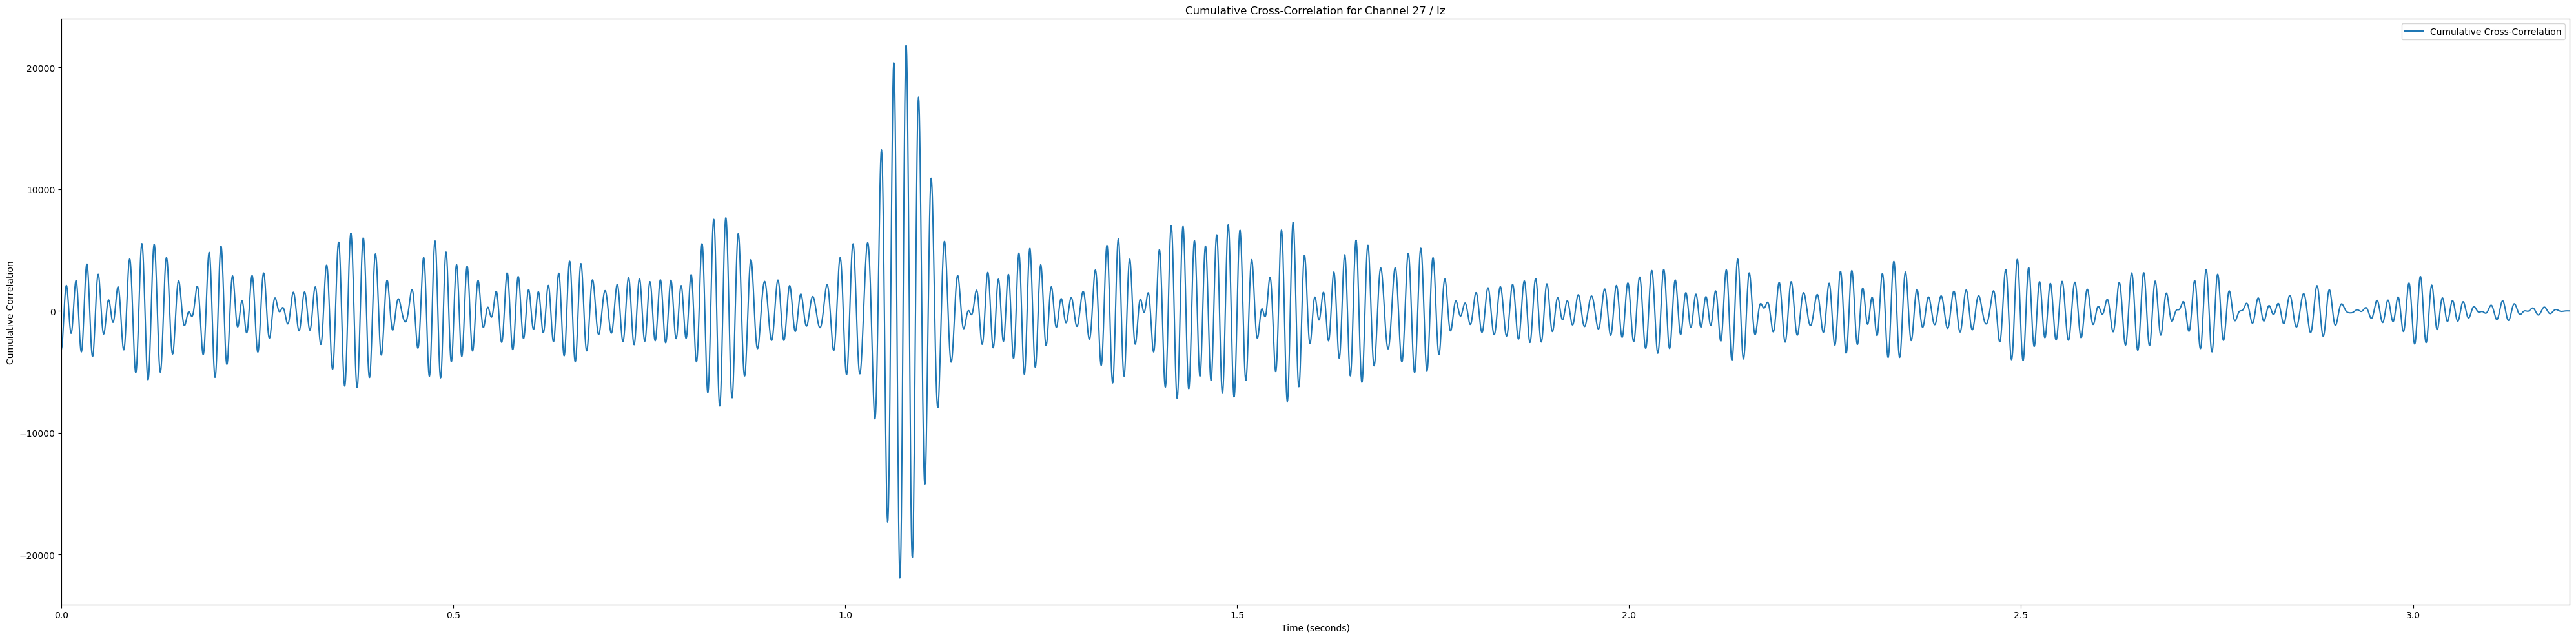

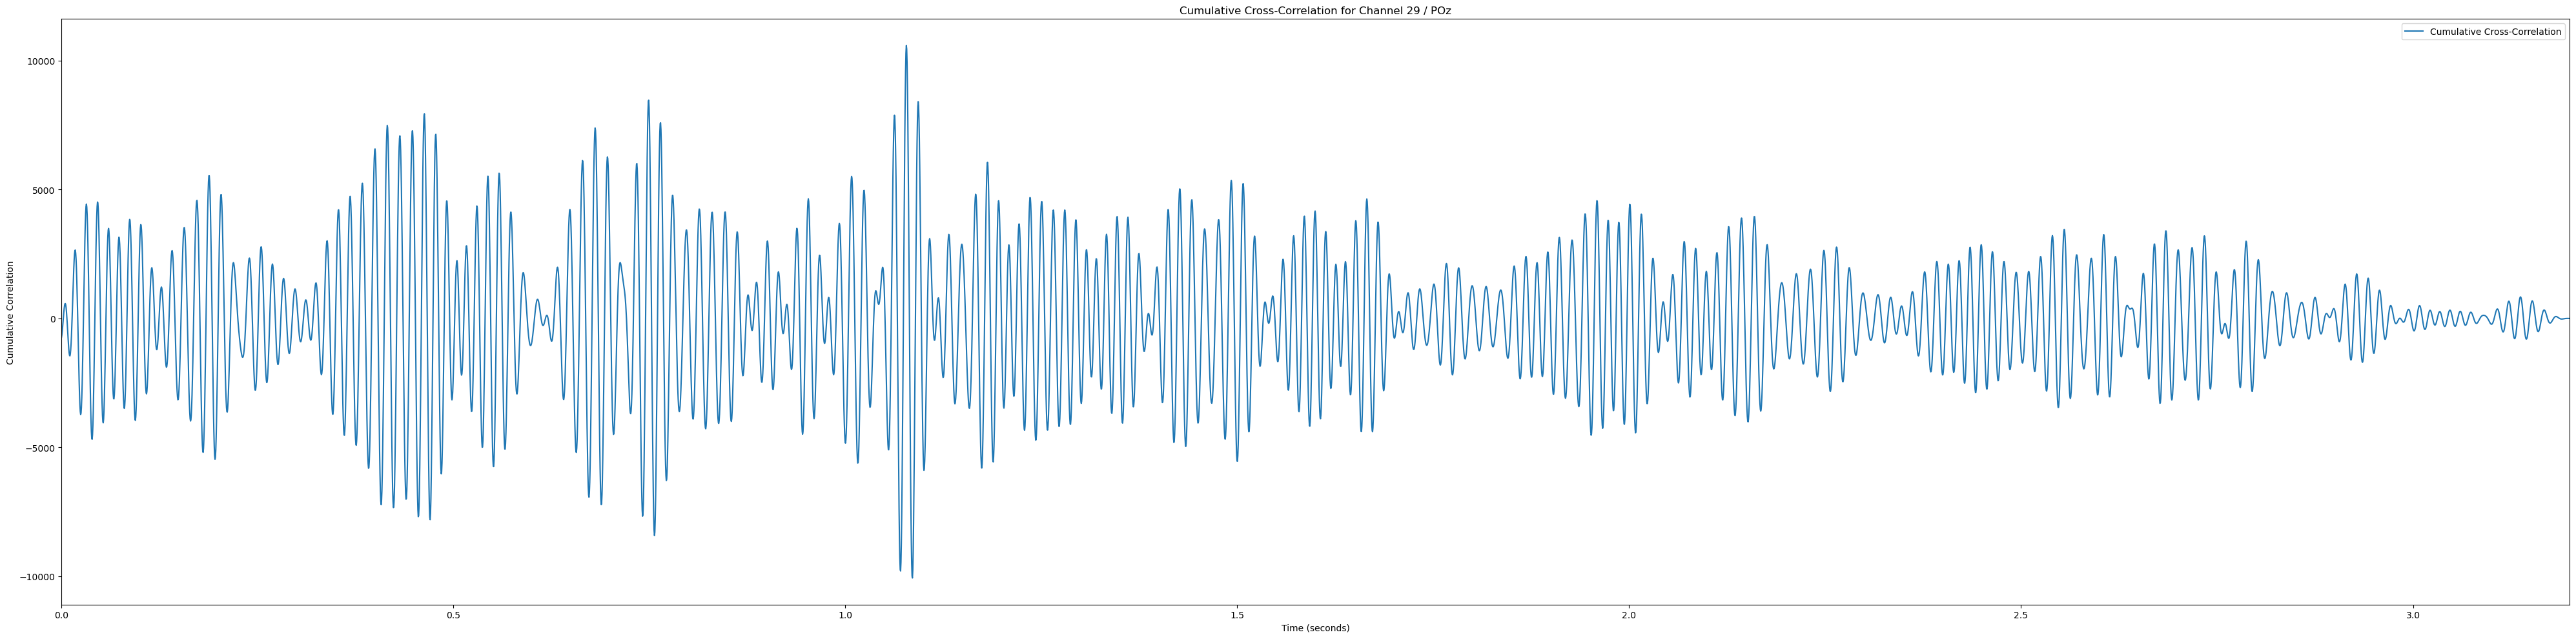

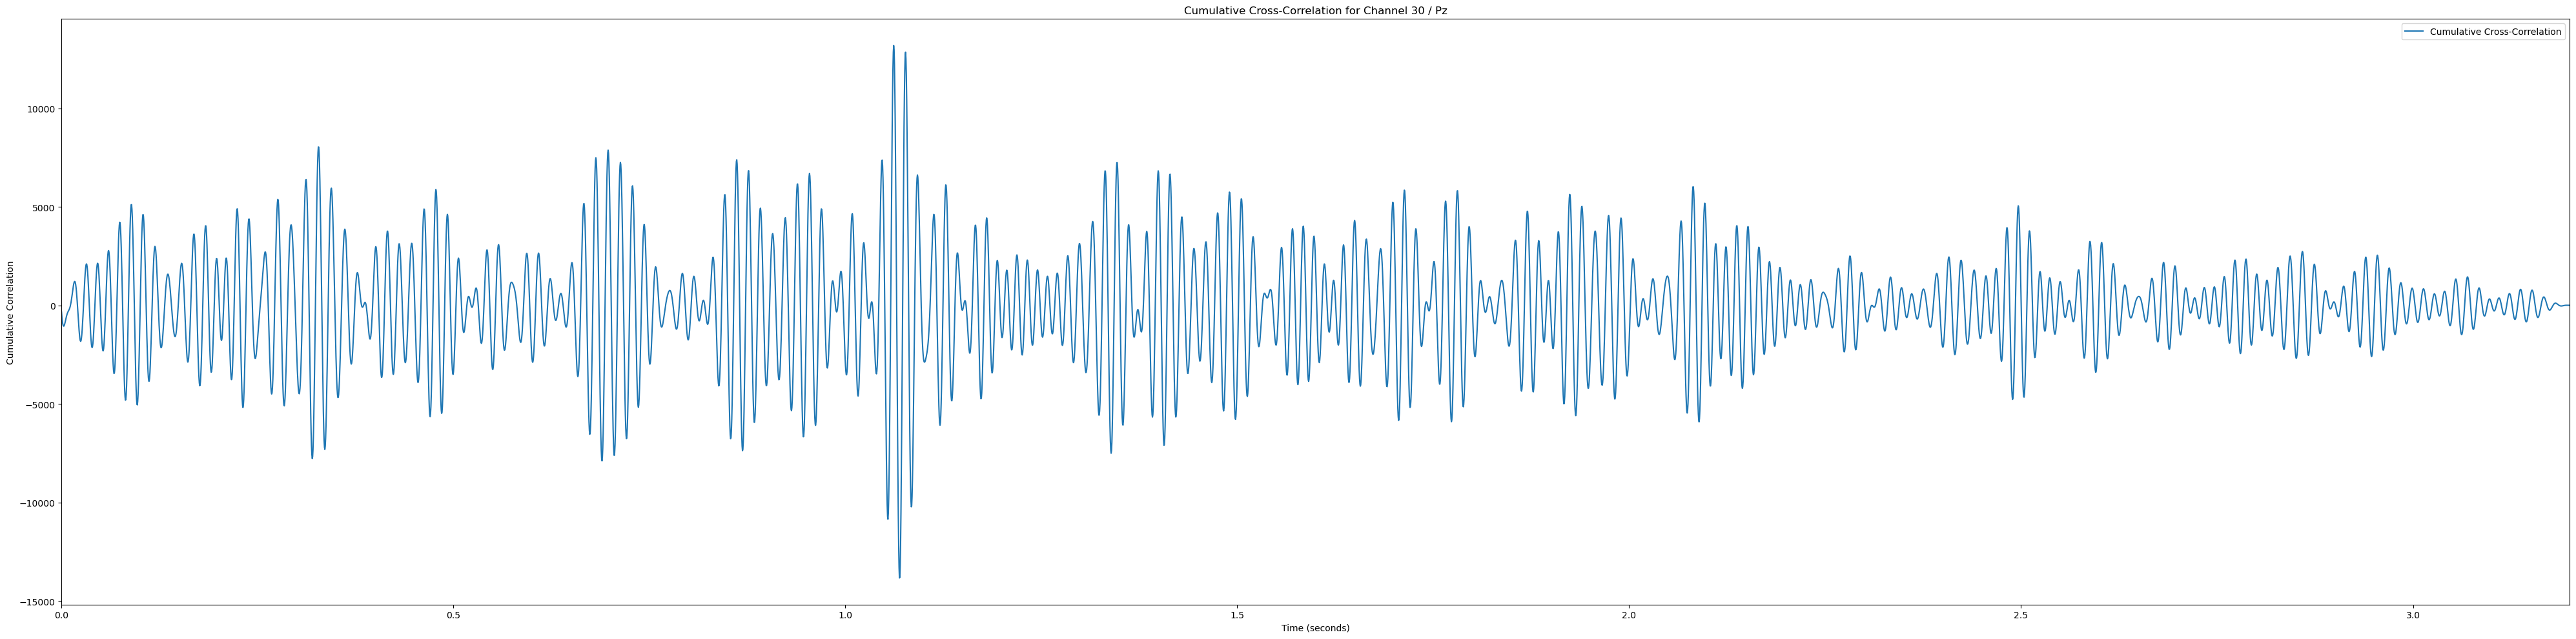

In [80]:
num_channels = eeg_data.shape[1]
noise_experiments = experiment_data[experiment_data['has_noise']]
print(noise_experiments.shape)
cross_corrs_all_trials = [[] for _ in range(num_channels)]

def process_experiment(experiment, channel_labels):
    eeg_data = experiment['eeg']
    noise_stim_left = experiment['noise_stim_left']
    noise_stim_right = experiment['noise_stim_right']

    lags, correlations = compute_best_combined_offset(eeg_data, noise_stim_left, noise_stim_right, channel_labels,
                                                      upsample_noise=True,
                                                      eeg_start_time=0.0, eeg_end_time=3.2,
                                                      noise_start_time=0.0, noise_end_time=2.15, # noise times present in the experiment
                                                    #   noise_start_time=4.0, noise_end_time=6.0, # noise times not present in the experiment
                                                      bandpass_eeg=(50, 80), bandpass_noise=(50, 80),
                                                    #   mix_noise_strength=0.2,
                                                      plot_results=False)
    # correlations = [interpolate_local_maxima(corr, 2048)[0] for corr in correlations]
    return correlations

def parallel_process_experiments(experiments, channel_labels, num_channels):
    cross_corrs_all_trials = [[] for _ in range(num_channels)]

    with ProcessPoolExecutor() as executor:
        futures = {executor.submit(process_experiment, experiment, channel_labels): i for i, experiment in experiments.iterrows()}

        for future in as_completed(futures):
            correlations = future.result()
            for channel in range(num_channels):
                cross_corrs_all_trials[channel].append(correlations[channel])

    return cross_corrs_all_trials

cross_corrs_all_trials = parallel_process_experiments(noise_experiments, channel_labels, num_channels)

pkl.dump({
    'cross_corrs_all_trials': cross_corrs_all_trials,
    'channel_labels': channel_labels,
}, open(f'../data/plot_data/cross_corrs_all_trials_{trial}.pkl', 'wb'))

# Plot heatmaps for each channel
sampling_rate = 2048
for channel, channel_label in enumerate(channel_labels):
    if channel_label not in ['Pz', 'POz', 'Iz', 'O1', 'PO3']: continue # Only plot the interesting occipital channels

    plt.figure(figsize=(40, 10))
    # Calculate and plot cumulative cross-correlation
    cumulative_corr = np.sum(np.array(cross_corrs_all_trials[channel]), axis=0)
    time_vector = np.linspace(0, len(cumulative_corr) / sampling_rate, len(cumulative_corr))

    plt.plot(time_vector, cumulative_corr, label='Cumulative Cross-Correlation')
    plt.title(f'Cumulative Cross-Correlation for Channel {channel + 1} / {channel_labels[channel]}')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Cumulative Correlation')
    plt.xlim(0, time_vector[-1])
    plt.legend()

    plt.tight_layout()
    plt.show()


(6758,)


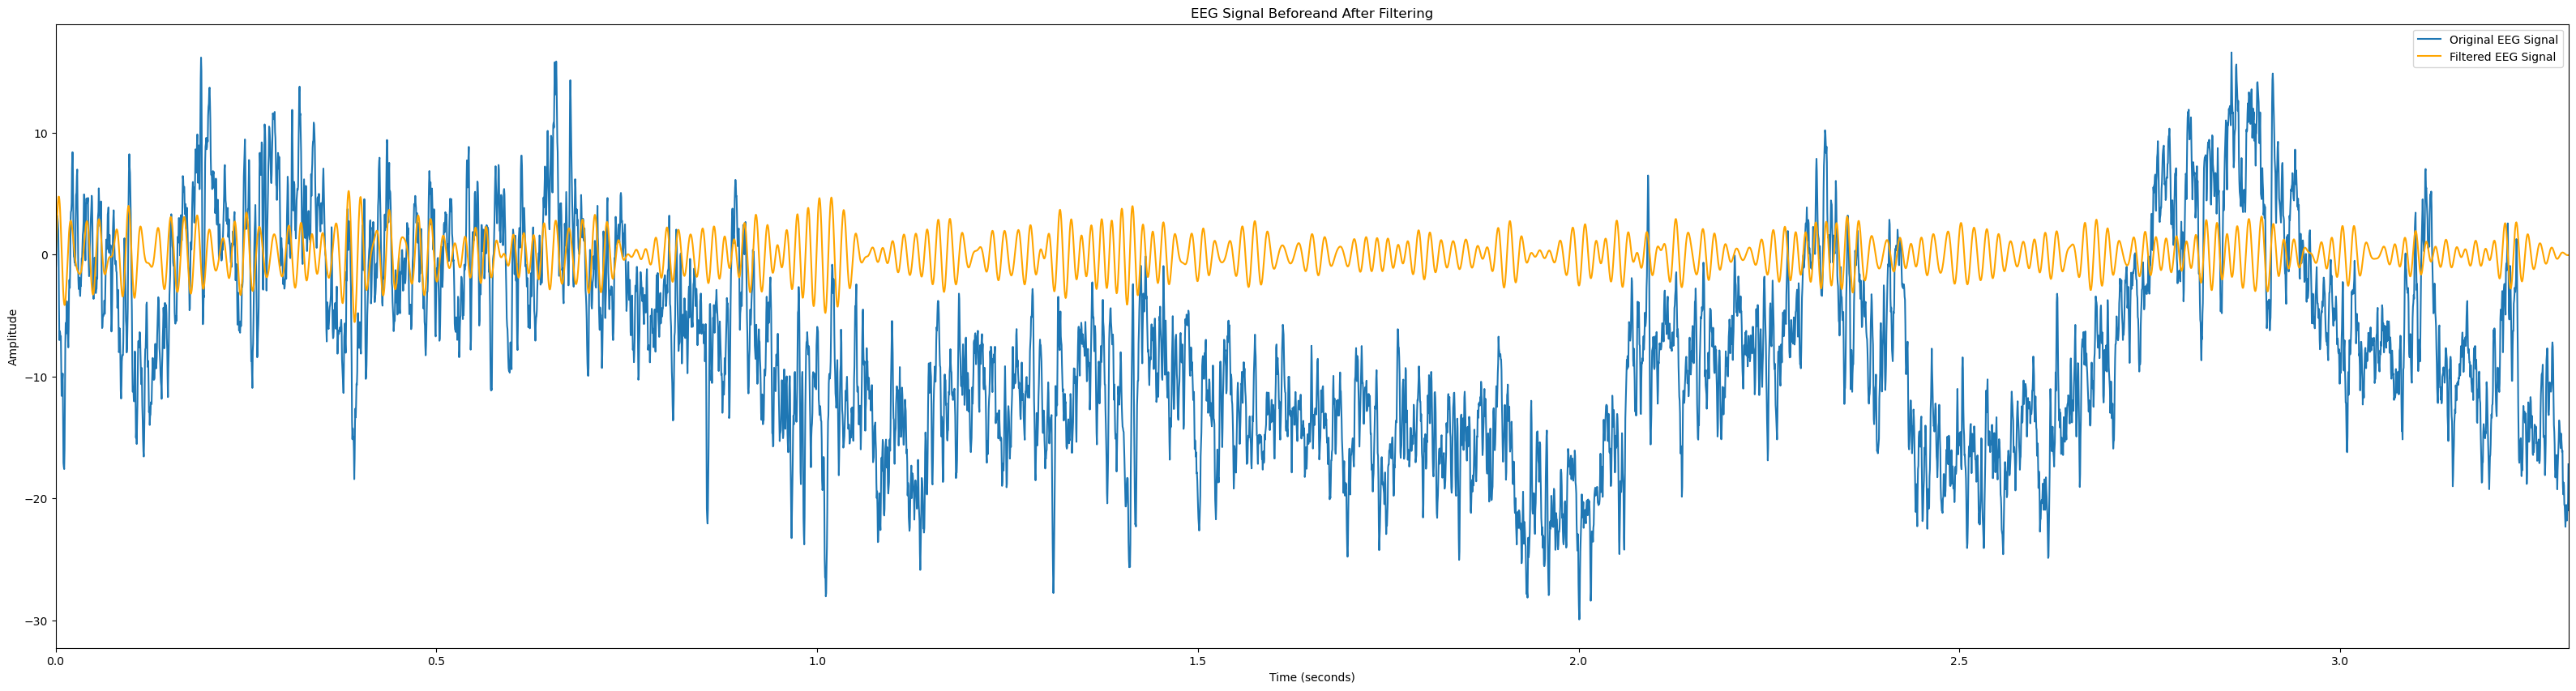

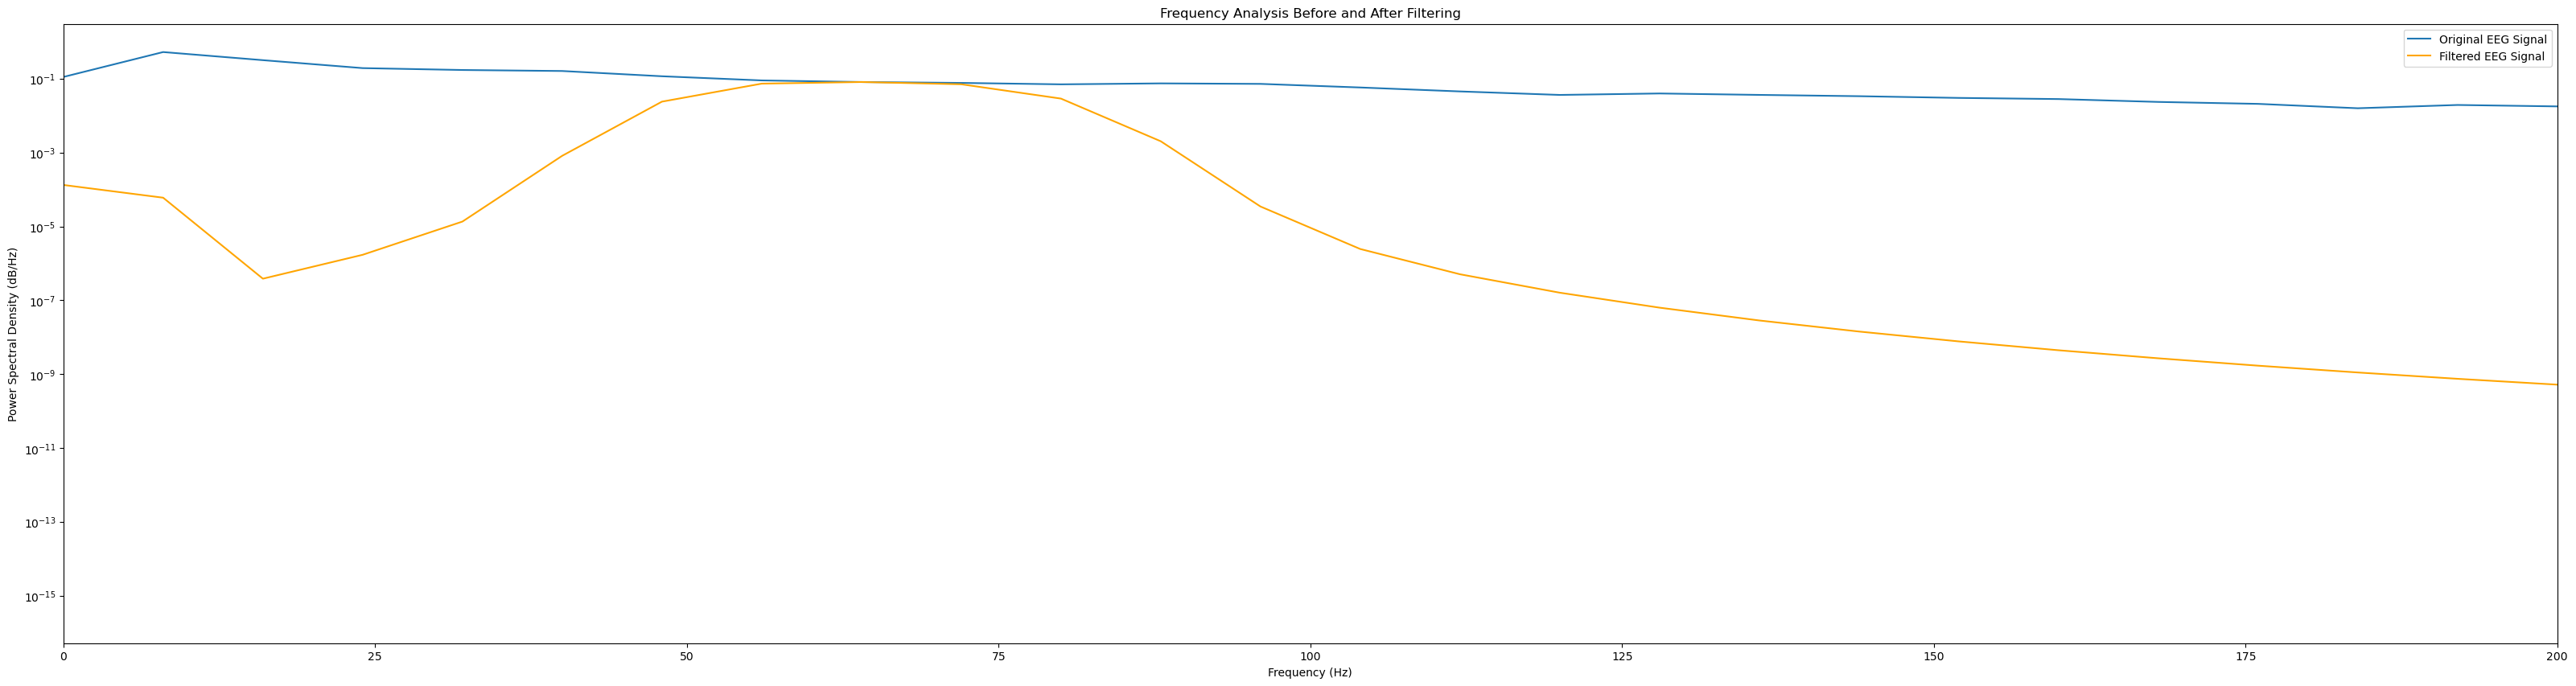

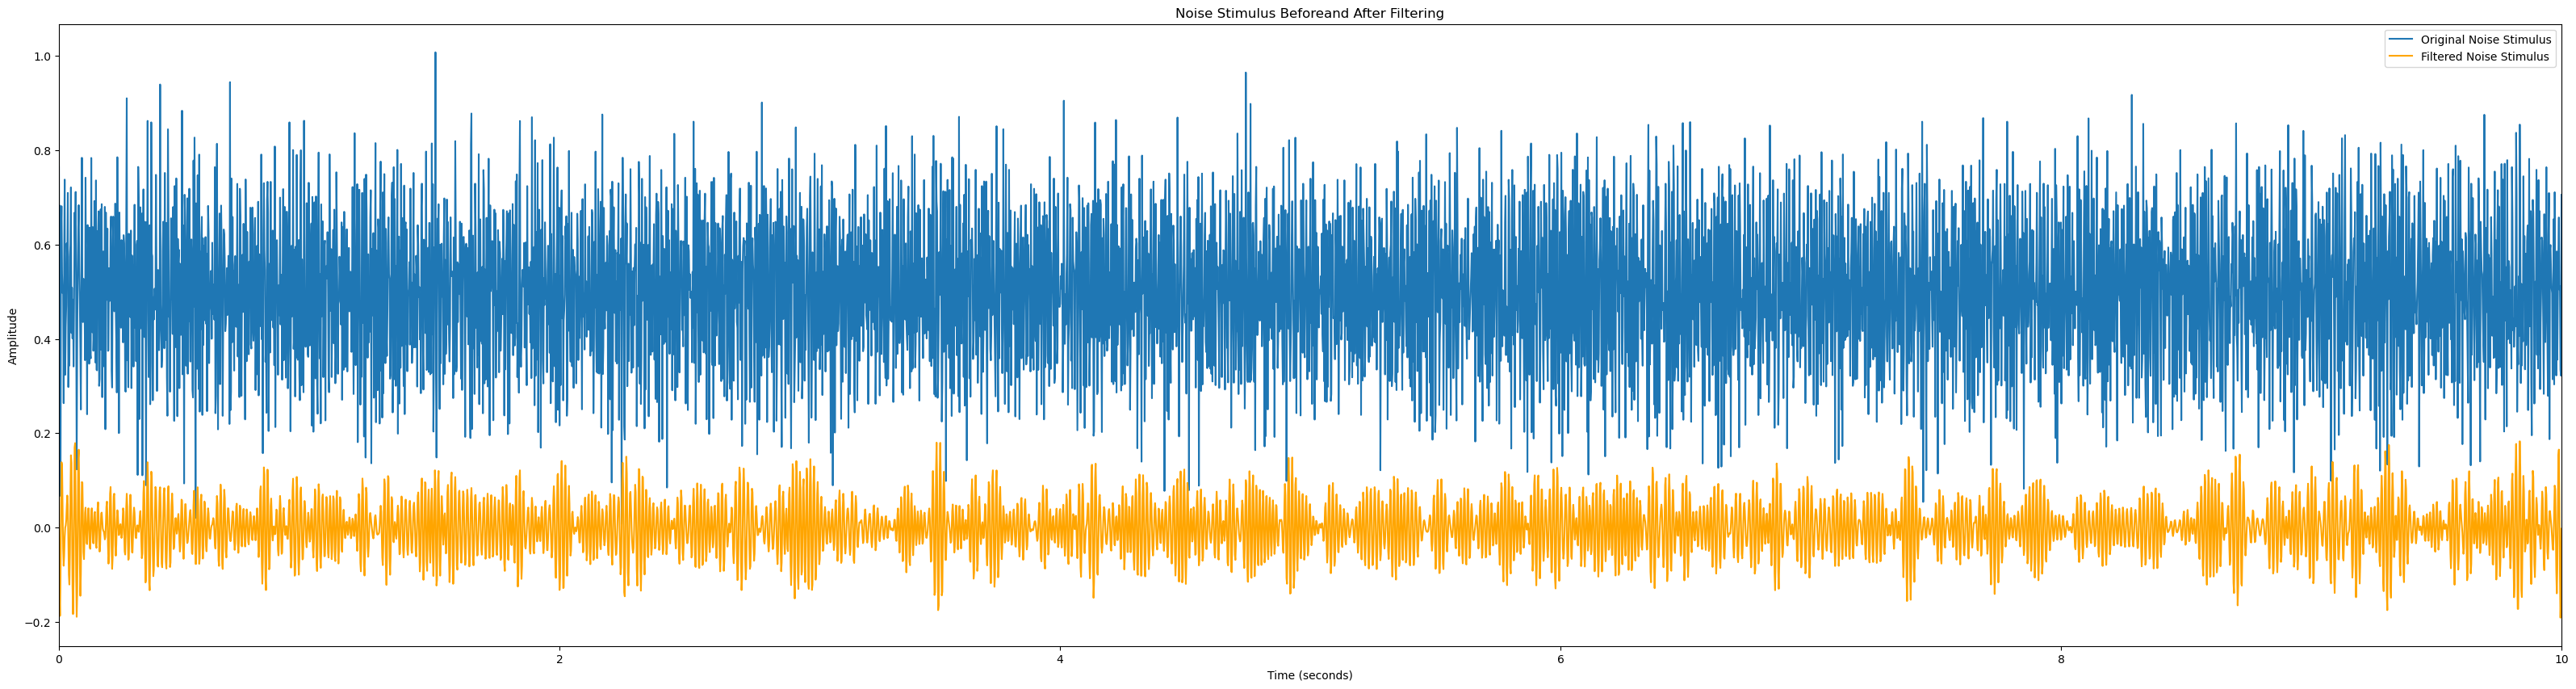

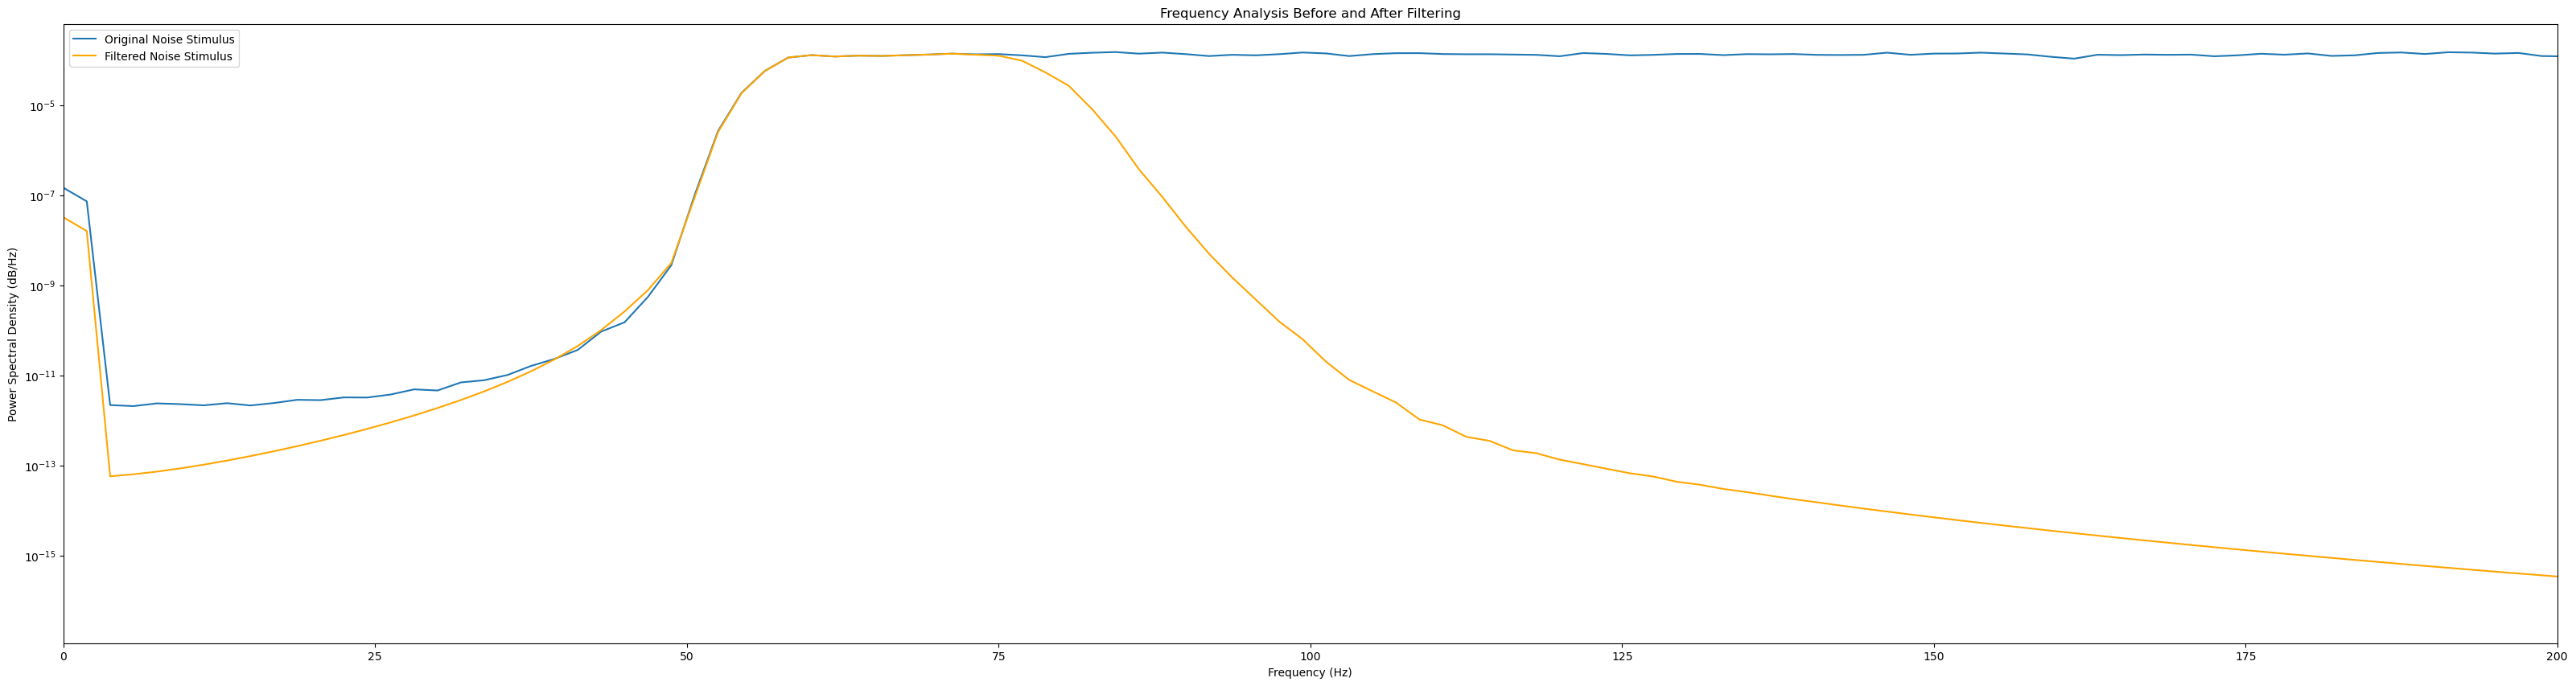

In [81]:
# Function to plot EEG channel before and after filtering
def plot_signal_filtering(signal, sampling_rate, lowcut, highcut, order=5, signal_name='EEG Signal'):
    # Apply bandpass filter
    filtered_signal = bandpass_filter(signal, lowcut, highcut, sampling_rate, order=order)

    # Time vector for plotting
    time_vector = np.linspace(0, len(signal) / sampling_rate, len(signal))

    # Plot EEG signal before and after filtering
    plt.figure(figsize=(40, 10))

    plt.plot(time_vector, signal, label=f'Original {signal_name}')
    plt.plot(time_vector, filtered_signal, label=f'Filtered {signal_name}', color='orange')
    plt.title(f'{signal_name} Beforeand After Filtering')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.xlim(0, len(signal) / sampling_rate)
    plt.legend()

    plt.show()

    # Frequency analysis before and after filtering
    freqs_before, psd_before = welch(signal, fs=sampling_rate)
    freqs_after, psd_after = welch(filtered_signal, fs=sampling_rate)

    plt.figure(figsize=(40, 10))

    plt.semilogy(freqs_before, psd_before, label=f'Original {signal_name}')
    plt.semilogy(freqs_after, psd_after, label=f'Filtered {signal_name}', color='orange')
    plt.title('Frequency Analysis Before and After Filtering')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density (dB/Hz)')
    plt.xlim(0, 200)
    plt.legend()

    plt.show()

skip = 2
for _, experiment in experiment_data.iterrows():
    if not experiment['has_noise']: continue
    if skip > 0:
        skip -= 1
        continue
    channel = 1
    eeg_data = experiment['eeg'][:, channel]
    noise_stim_left = experiment['noise_stim_left']
    print(eeg_data.shape)
    plot_signal_filtering(eeg_data, sampling_rate=2048, lowcut=50, highcut=80)
    plot_signal_filtering(noise_stim_left, sampling_rate=480, lowcut=50, highcut=80, signal_name='Noise Stimulus')
    break

# Topography plot of SNR's

Fp1 0.4697265625
AF7 0.0009765625
AF3 1.15771484375
F1 0.09619140625
F3 0.890625
F5 0.23046875
F7 0.76708984375
FT7 0.33935546875
FC5 0.42578125
FC3 0.001953125
FC1 0.82568359375
C1 0.86083984375
C3 0.59228515625
C5 0.6083984375
T7 0.4580078125
TP7 1.40380859375
CP5 0.87646484375
CP3 0.86181640625
CP1 1.5703125
P1 1.06103515625
P3 1.06201171875
P5 1.07763671875
P7 0.36865234375
PO7 0.84912109375
PO3 1.06103515625
O1 1.0771484375
Iz 1.0771484375
Oz 0.6806640625
POz 1.07763671875
Pz 1.0615234375
P2 1.04638671875
P4 0.86083984375
P6 0.88427734375
P8 0.7626953125
PO8 0.03857421875
PO4 0.8388671875
O2 0.86865234375


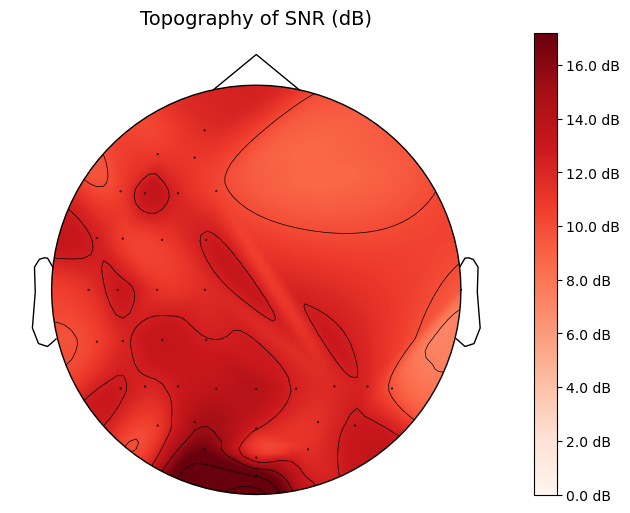

In [82]:
def calculate_snr(cross_corrs_all_trials, sampling_rate, expected_peak_time=None):
    snrs = []
    for i, channel_corrs in enumerate(cross_corrs_all_trials):
        cumulative_corr = np.sum(channel_corrs, axis=0)
        # Time vector for the cross-correlation
        # time_vector = np.linspace(0, len(cumulative_corr) / sampling_rate, len(cumulative_corr))

        if expected_peak_time is not None:
            # Find the peak closest to the expected peak time
            peak_signal = np.max(cumulative_corr[int((expected_peak_time - 0.1)*sampling_rate):
                                                 int((expected_peak_time + 0.1)*sampling_rate)])
            print(channel_labels[i],
                (np.argmax(cumulative_corr[int((expected_peak_time - 0.1)*sampling_rate):
                                             int((expected_peak_time + 0.1)*sampling_rate)])/sampling_rate) + expected_peak_time)
        else:
            # Find the highest peak in the cross-correlation
            print(channel_labels[i], np.argmax(cumulative_corr)/sampling_rate)
            peak_signal = np.max(cumulative_corr)

        # Calculate the noise as the standard deviation of the cross-correlation
        noise = np.std(cumulative_corr)  # Assuming this represents the noise
        snr = 10 * np.log10(peak_signal**2 / noise**2)
        snrs.append(snr)
    return snrs

# Plot topography
def plot_topography(snr_values, channel_labels, sampling_rate):
    info = mne.create_info(ch_names=channel_labels, sfreq=sampling_rate, ch_types='eeg')

    # Use a standard montage for electrode positions
    montage = mne.channels.make_standard_montage('biosemi64')
    info.set_montage(montage)

    # Create Evoked object with SNR values
    evoked_data = np.array(snr_values).reshape(-1, 1)
    evoked = mne.EvokedArray(evoked_data, info)

    # Plot topography
    fig, ax = plt.subplots(figsize=(8, 6))
    im, cn = mne.viz.plot_topomap(evoked.data[:, 0], evoked.info, axes=ax, show=False)
    fig.colorbar(im, ax=ax, format="%0.1f dB")
    ax.set_title('Topography of SNR (dB)', fontsize=14)
    plt.show()

expected_peak_time = 1.1678203125 # Manual peak times for testing, can be discovered from the correlations
expected_peak_time = 1.1775859375
snr_values = calculate_snr(cross_corrs_all_trials, sampling_rate)

pkl.dump({
    'snr_values': snr_values,
    'channel_labels': channel_labels,
    'sampling_rate': sampling_rate,
}, open(f'../data/plot_data/snr_values_{trial}.pkl', 'wb'))

plot_topography(snr_values, channel_labels, sampling_rate)


# Cued vs Uncued Coherence

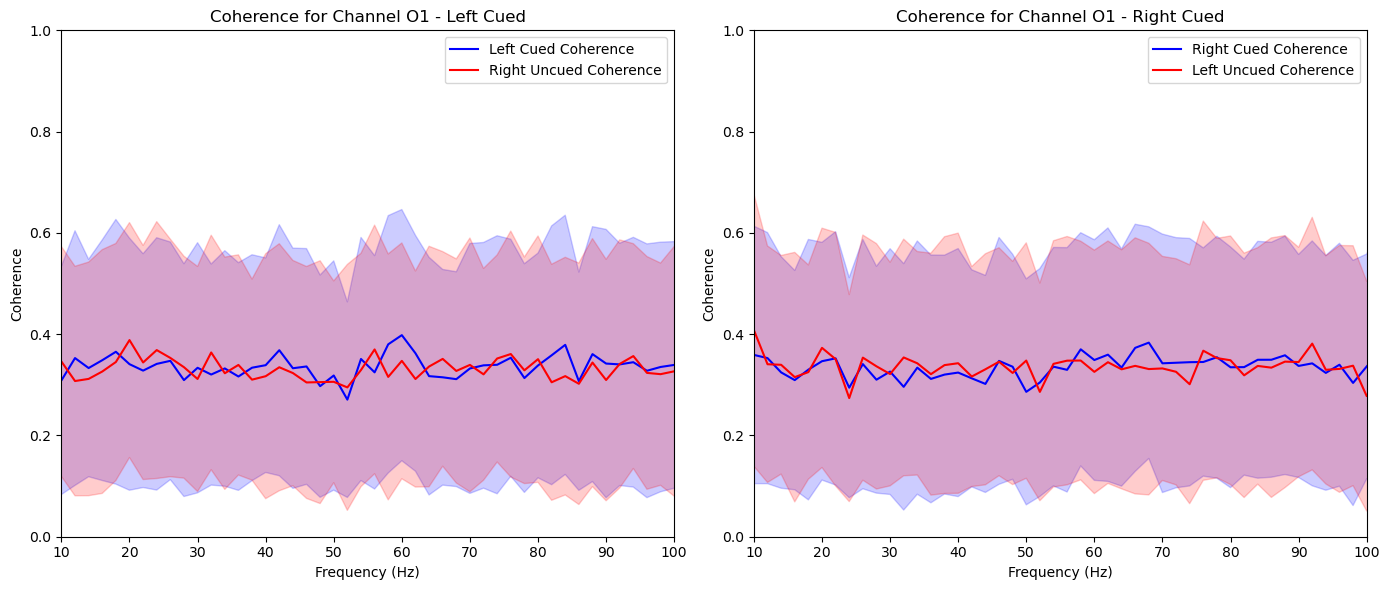

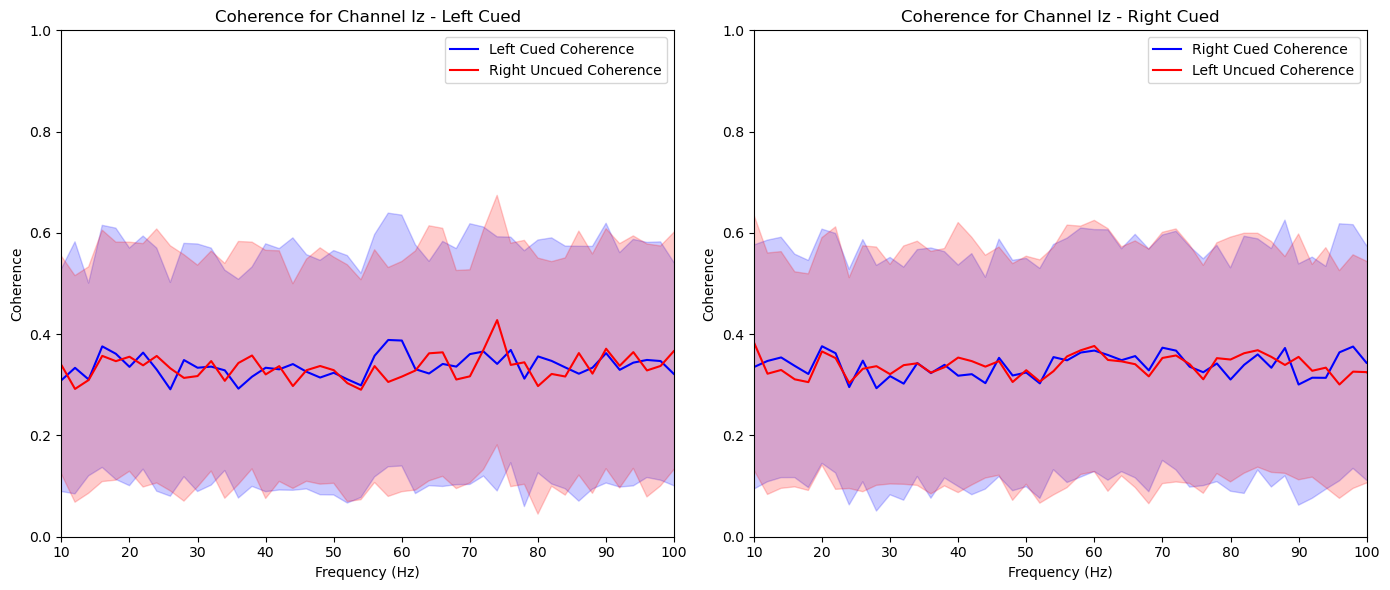

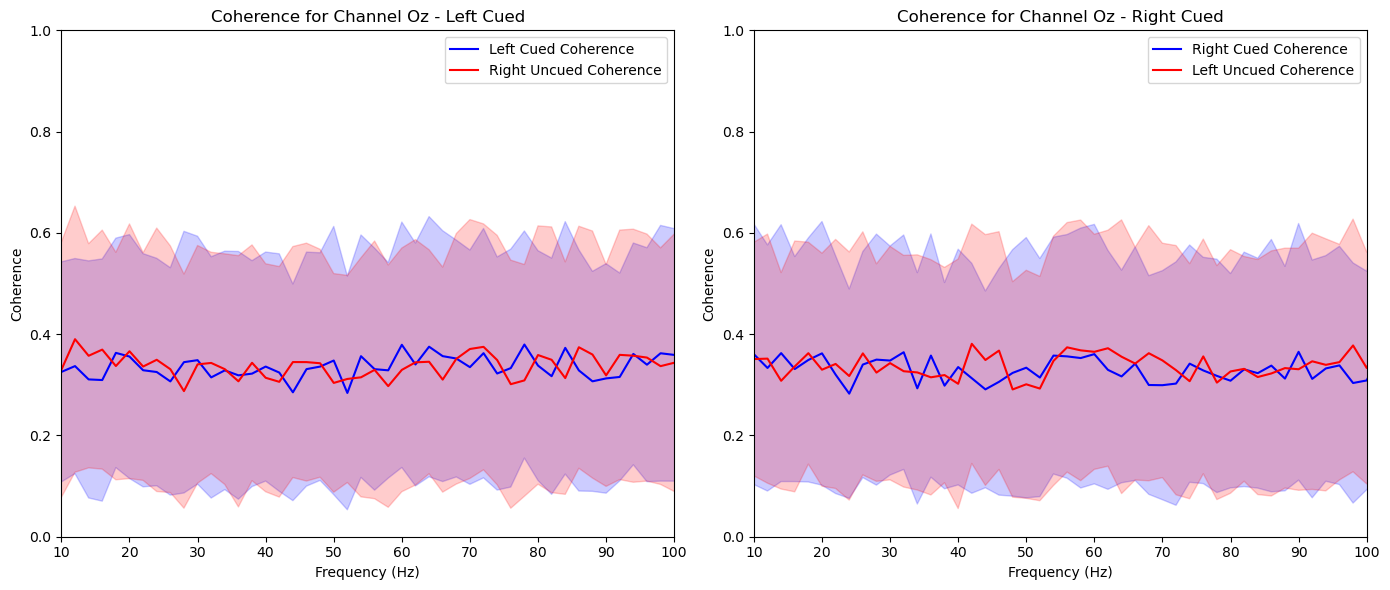

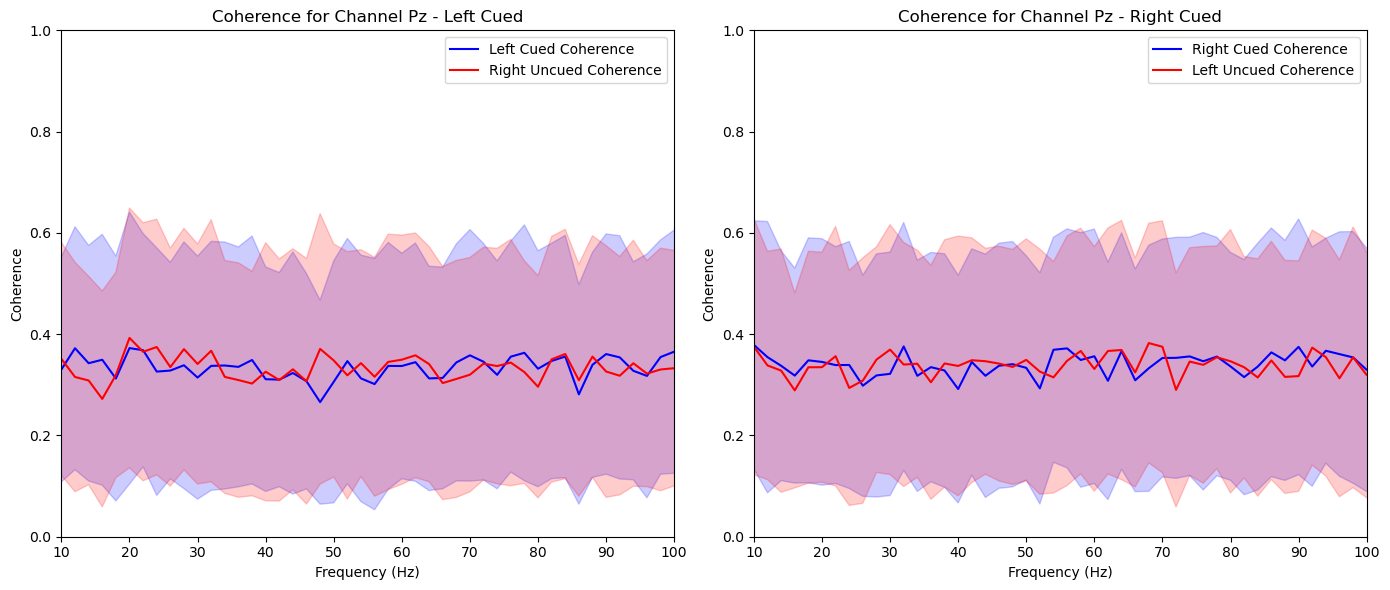

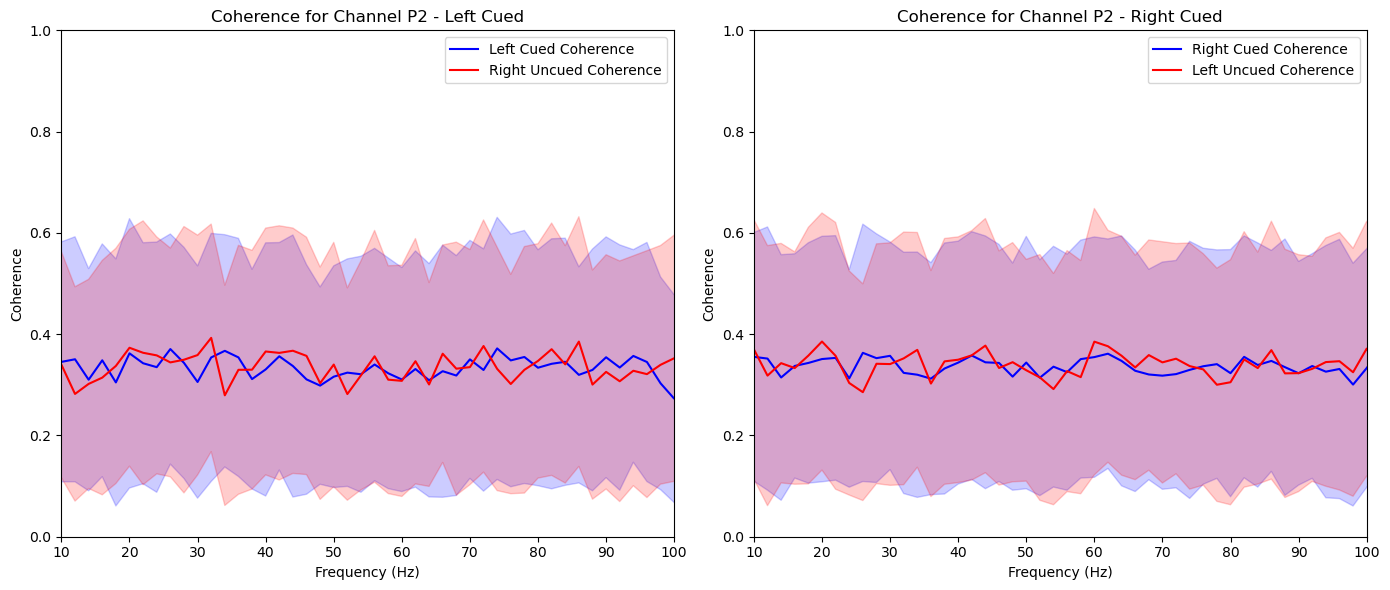

In [83]:
def determine_coherence_per_trial(eeg_data, noise_stim_left, noise_stim_right, channel_labels, channel_selection, lags,
                                  sampling_rate=2048, noise_sample_rate=480, wiggle=0,
                                  upsample_noise=True, eeg_start_time=0.0, eeg_end_time=3.2,
                                  noise_start_time=0.0, noise_end_time=2.0,
                                  bandpass_eeg=None, bandpass_noise=None, freq_band=(50, 80)):
    num_samples, num_channels = eeg_data.shape
    eeg_segment_start = int(eeg_start_time * sampling_rate)
    eeg_segment_end = int(eeg_end_time * sampling_rate)

    # Select EEG segment
    eeg_data_segment = eeg_data[eeg_segment_start:eeg_segment_end, :].copy()

    # Select noise segment
    noise_segment_start = int(noise_start_time * noise_sample_rate)
    noise_segment_end = int(noise_end_time * noise_sample_rate)
    noise_stim_left_segment = noise_stim_left[noise_segment_start:noise_segment_end].copy()
    noise_stim_right_segment = noise_stim_right[noise_segment_start:noise_segment_end].copy()

    # Optionally bandpass filter the signals
    if bandpass_eeg:
        lowcut, highcut = bandpass_eeg
        for channel in range(num_channels):
            eeg_data_segment[:, channel] = bandpass_filter_sos(eeg_data_segment[:, channel], lowcut, highcut, sampling_rate)

    if bandpass_noise:
        lowcut, highcut = bandpass_noise
        noise_stim_left_segment = bandpass_filter_sos(noise_stim_left_segment, lowcut, highcut, noise_sample_rate)
        noise_stim_right_segment = bandpass_filter_sos(noise_stim_right_segment, lowcut, highcut, noise_sample_rate)

    # Upsample or downsample the noise signals
    if upsample_noise:
        noise_stim_left_segment = upsample_or_downsample(noise_stim_left_segment, noise_sample_rate, sampling_rate)
        noise_stim_right_segment = upsample_or_downsample(noise_stim_right_segment, noise_sample_rate, sampling_rate)
    else:
        eeg_data_segment = upsample_or_downsample(eeg_data_segment, sampling_rate, noise_sample_rate)
        sampling_rate = noise_sample_rate

    # Normalise the signals before calculating coherence
    noise_stim_left_segment = normalise_signal(noise_stim_left_segment)
    noise_stim_right_segment = normalise_signal(noise_stim_right_segment)
    eeg_data_segment = normalise_signal(eeg_data_segment)

    left_coherence = defaultdict(list)
    right_coherence = defaultdict(list)

    for channel, channel_label in enumerate(channel_labels):
        if channel_label not in channel_selection:
            continue

        base_lag = lags[channel_label]
        best_lag = base_lag
        best_coherence_sum = -np.inf

        # Check coherence sums within the wiggle room
        for delta in range(-wiggle, wiggle + 1):
            current_lag = base_lag + delta
            eeg_aligned = eeg_data_segment[:, channel][current_lag:current_lag + len(noise_stim_left_segment)]
            delay = int(sampling_rate * 1)
            f, coh_left = coherence(eeg_aligned[delay:len(eeg_aligned)], noise_stim_left_segment[delay:len(eeg_aligned)], fs=sampling_rate, nperseg=1024)
            f, coh_right = coherence(eeg_aligned[delay:len(eeg_aligned)], noise_stim_right_segment[delay:len(eeg_aligned)], fs=sampling_rate, nperseg=1024)

            freq_indices = np.where((f >= freq_band[0]) & (f <= freq_band[1]))[0]
            coh_left_band = np.mean(coh_left[freq_indices], axis=0)
            coh_right_band = np.mean(coh_right[freq_indices], axis=0)
            coherence_sum = np.sum(coh_left_band) + np.sum(coh_right_band)

            if coherence_sum > best_coherence_sum:
                best_coherence_sum = coherence_sum
                best_lag = current_lag

        # Recompute coherence with the best lag
        eeg_aligned_best = eeg_data_segment[:, channel][best_lag:best_lag + len(noise_stim_left_segment)]
        delay = int(sampling_rate * 1)
        f, coh_left_best = coherence(eeg_aligned_best[delay:len(eeg_aligned_best)], noise_stim_left_segment[delay:len(eeg_aligned_best)], fs=sampling_rate, nperseg=1024)
        f, coh_right_best = coherence(eeg_aligned_best[delay:len(eeg_aligned_best)], noise_stim_right_segment[delay:len(eeg_aligned_best)], fs=sampling_rate, nperseg=1024)

        left_coherence[channel_label].append(coh_left_best)
        right_coherence[channel_label].append(coh_right_best)

    return left_coherence, right_coherence, f

def aggregate_and_plot_coherence(experiments, channel_labels, lags, sampling_rate=2048, noise_sample_rate=480, plot_channels=None):
    aggregated_left_cued = defaultdict(list)
    aggregated_left_uncued = defaultdict(list)
    aggregated_right_cued = defaultdict(list)
    aggregated_right_uncued = defaultdict(list)
    freqs = None

    for _, experiment in experiments.iterrows():
        eeg_data = experiment['eeg']
        noise_stim_left = experiment['noise_stim_left']
        noise_stim_right = experiment['noise_stim_right']
        attended_side = experiment['attended_side']

        left_coherence, right_coherence, freqs = determine_coherence_per_trial(
            eeg_data, noise_stim_left, noise_stim_right, channel_labels, plot_channels, lags,
            sampling_rate=sampling_rate, noise_sample_rate=noise_sample_rate,
            upsample_noise=True, eeg_start_time=0.0, eeg_end_time=3.2,
            noise_start_time=0.0, noise_end_time=2.15, wiggle=2
        )

        if attended_side == 0:
            for channel_label in channel_labels:
                aggregated_left_cued[channel_label].append(left_coherence[channel_label])
                aggregated_right_uncued[channel_label].append(right_coherence[channel_label])
        else:
            for channel_label in channel_labels:
                aggregated_right_cued[channel_label].append(right_coherence[channel_label])
                aggregated_left_uncued[channel_label].append(left_coherence[channel_label])

    # Plot coherence
    if plot_channels is None:
        plot_channels = channel_labels

    pkl.dump({
        'freqs': freqs,
        'aggregated_left_cued': aggregated_left_cued,
        'aggregated_left_uncued': aggregated_left_uncued,
        'aggregated_right_cued': aggregated_right_cued,
        'aggregated_right_uncued': aggregated_right_uncued,
    }, open(f'../data/plot_data/coherence_values_{trial}.pkl', 'wb'))

    for channel_label in plot_channels:
        mean_left_cued = np.squeeze(np.mean(aggregated_left_cued[channel_label], axis=0))
        mean_left_uncued = np.squeeze(np.mean(aggregated_left_uncued[channel_label], axis=0))
        mean_right_cued = np.squeeze(np.mean(aggregated_right_cued[channel_label], axis=0))
        mean_right_uncued = np.squeeze(np.mean(aggregated_right_uncued[channel_label], axis=0))

        std_left_cued = np.squeeze(np.std(aggregated_left_cued[channel_label], axis=0))
        std_left_uncued = np.squeeze(np.std(aggregated_left_uncued[channel_label], axis=0))
        std_right_cued = np.squeeze(np.std(aggregated_right_cued[channel_label], axis=0))
        std_right_uncued = np.squeeze(np.std(aggregated_right_uncued[channel_label], axis=0))

        plt.figure(figsize=(14, 6))

        # Left cued and uncued plot
        plt.subplot(1, 2, 1)
        plt.plot(freqs, mean_left_cued, color='blue', label='Left Cued Coherence')
        plt.fill_between(freqs, mean_left_cued - std_left_cued, mean_left_cued + std_left_cued, color='blue', alpha=0.2)
        plt.plot(freqs, mean_right_uncued, color='red', label='Right Uncued Coherence')
        plt.fill_between(freqs, mean_right_uncued - std_right_uncued, mean_right_uncued + std_right_uncued, color='red', alpha=0.2)
        plt.title(f'Coherence for Channel {channel_label} - Left Cued')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Coherence')
        plt.legend()
        plt.xlim(10, 100)
        plt.ylim(0, 1)
        # Right cued and uncued plot
        plt.subplot(1, 2, 2)
        plt.plot(freqs, mean_right_cued, color='blue', label='Right Cued Coherence')
        plt.fill_between(freqs, mean_right_cued - std_right_cued, mean_right_cued + std_right_cued, color='blue', alpha=0.2)
        plt.plot(freqs, mean_left_uncued, color='red', label='Left Uncued Coherence')
        plt.fill_between(freqs, mean_left_uncued - std_left_uncued, mean_left_uncued + std_left_uncued, color='red', alpha=0.2)
        plt.title(f'Coherence for Channel {channel_label} - Right Cued')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Coherence')
        plt.legend()
        plt.xlim(10, 100)
        plt.ylim(0, 1)
        plt.tight_layout()
        plt.show()

noise_experiments = experiment_data[experiment_data['has_noise']]
lags = {}
for channel_corrs, channel_label in zip(cross_corrs_all_trials, channel_labels):
    cumulative_corr = np.sum(channel_corrs, axis=0)
    lag = np.argmax(cumulative_corr)
    lags[channel_label] = lag
aggregate_and_plot_coherence(noise_experiments, channel_labels, lags, plot_channels=['O1', 'Iz', 'Oz', 'Pz', 'P2'])

In [87]:
def predict_cued_side(experiments, channel_labels, lags, sampling_rate=2048, noise_sample_rate=480, freq_band=(50, 80)):
    predictions = {channel: [] for channel in channel_labels}
    actual_sides = []

    for _, experiment in experiments.iterrows():
        eeg_data = experiment['eeg']
        noise_stim_left = experiment['noise_stim_left']
        noise_stim_right = experiment['noise_stim_right']
        attended_side = experiment['attended_side']

        left_coherence, right_coherence, freqs = determine_coherence_per_trial(
            eeg_data, noise_stim_left, noise_stim_right, channel_labels, channel_labels, lags,
            sampling_rate=sampling_rate, noise_sample_rate=noise_sample_rate,
            upsample_noise=True, eeg_start_time=0.0, eeg_end_time=3.2,
            noise_start_time=0.0, noise_end_time=2.15,
            wiggle=2,
        )

        actual_sides.append(attended_side)

        freq_indices = np.where((freqs >= freq_band[0]) & (freqs <= freq_band[1]))[0]

        for channel_label in channel_labels:
            left_coherence_array = np.array(left_coherence[channel_label])
            right_coherence_array = np.array(right_coherence[channel_label])

            mean_coh_left = np.mean(left_coherence_array[:, freq_indices])
            mean_coh_right = np.mean(right_coherence_array[:, freq_indices])

            # Predict side: False for left, True for right
            predicted_side = mean_coh_right > mean_coh_left
            predictions[channel_label].append(predicted_side)

    # Calculate accuracy per channel
    channel_accuracies = {}
    for channel_label in channel_labels:
        channel_predictions = np.array(predictions[channel_label])
        accuracy = accuracy_score(actual_sides, channel_predictions)
        channel_accuracies[channel_label] = accuracy

    return channel_accuracies, predictions, actual_sides

def majority_voting(predictions, actual_sides, selected_channels):
    majority_predictions = []

    for i in range(len(actual_sides)):
        selected_predictions = [predictions[channel][i] for channel in selected_channels]
        predicted_side = np.mean(selected_predictions) > 0.5
        majority_predictions.append(predicted_side)

    overall_accuracy = accuracy_score(actual_sides, majority_predictions)
    return overall_accuracy

noise_experiments = experiment_data[experiment_data['has_noise']]
lags = {}
for channel_corrs, channel_label in zip(cross_corrs_all_trials, channel_labels):
    cumulative_corr = np.sum(channel_corrs, axis=0)
    lag = np.argmax(cumulative_corr)
    lags[channel_label] = lag

most_frequent_lag = max(set(lags.values()), key=list(lags.values()).count)
print('Most frequent lag:', most_frequent_lag)
threshold = 0.2 * sampling_rate
adjusted_lags = {k: (most_frequent_lag if abs(v - most_frequent_lag) >= threshold else v) for k, v in lags.items()}

# Make all the lags the same
# lags_ = {k: most_frequent_lag for k in lags}

# Predict cued side and calculate accuracy per channel
channel_accuracies, predictions, actual_sides = predict_cued_side(noise_experiments, channel_labels, adjusted_lags, freq_band=(50, 80))

# Print accuracy for each channel
for channel, accuracy in channel_accuracies.items():
    print(f'Channel {channel}: Accuracy = {accuracy:.2f}')

# Perform majority voting using selected channels
selected_channels = ['PO4', 'POz', 'P7']
overall_accuracy = majority_voting(predictions, actual_sides, selected_channels)
print(f'Overall accuracy with majority voting: {overall_accuracy:.2f}')

Most frequent lag: 2206
Channel Fp1: Accuracy = 0.46
Channel AF7: Accuracy = 0.49
Channel AF3: Accuracy = 0.50
Channel F1: Accuracy = 0.49
Channel F3: Accuracy = 0.48
Channel F5: Accuracy = 0.51
Channel F7: Accuracy = 0.46
Channel FT7: Accuracy = 0.54
Channel FC5: Accuracy = 0.51
Channel FC3: Accuracy = 0.49
Channel FC1: Accuracy = 0.52
Channel C1: Accuracy = 0.48
Channel C3: Accuracy = 0.54
Channel C5: Accuracy = 0.45
Channel T7: Accuracy = 0.52
Channel TP7: Accuracy = 0.54
Channel CP5: Accuracy = 0.53
Channel CP3: Accuracy = 0.50
Channel CP1: Accuracy = 0.52
Channel P1: Accuracy = 0.51
Channel P3: Accuracy = 0.51
Channel P5: Accuracy = 0.51
Channel P7: Accuracy = 0.55
Channel PO7: Accuracy = 0.52
Channel PO3: Accuracy = 0.52
Channel O1: Accuracy = 0.50
Channel Iz: Accuracy = 0.50
Channel Oz: Accuracy = 0.43
Channel POz: Accuracy = 0.61
Channel Pz: Accuracy = 0.49
Channel P2: Accuracy = 0.51
Channel P4: Accuracy = 0.48
Channel P6: Accuracy = 0.48
Channel P8: Accuracy = 0.50
Channel PO

In [94]:
def process_experiment(experiment, channel_labels, lags, sampling_rate=2048, noise_sample_rate=480, freq_band=(50, 80), full=False):
    eeg_data = experiment['eeg']
    noise_stim_left = experiment['noise_stim_left']
    noise_stim_right = experiment['noise_stim_right']
    attended_side = experiment['attended_side']

    left_coherence, right_coherence, freqs = determine_coherence_per_trial(
        eeg_data, noise_stim_left, noise_stim_right, channel_labels, channel_labels, lags,
        sampling_rate=sampling_rate, noise_sample_rate=noise_sample_rate,
        upsample_noise=True, eeg_start_time=0.0, eeg_end_time=3.2,
        noise_start_time=0.0, noise_end_time=2,
        wiggle=2,
    )

    freq_indices = np.where((freqs >= freq_band[0]) & (freqs <= freq_band[1]))[0]
    trial_features = []

    for channel_label in channel_labels:
        left_coherence_array = np.array(left_coherence[channel_label])
        right_coherence_array = np.array(right_coherence[channel_label])

        if full:
            coh_left = left_coherence_array[:, freq_indices].flatten()
            coh_right = right_coherence_array[:, freq_indices].flatten()

            trial_features.extend(coh_left)
            trial_features.extend(coh_right)
        else:
            mean_coh_left = np.mean(left_coherence_array[:, freq_indices])
            mean_coh_right = np.mean(right_coherence_array[:, freq_indices])

            trial_features.append(mean_coh_left)
            trial_features.append(mean_coh_right)

    return trial_features, attended_side

def extract_features(experiments, channel_labels, lags, sampling_rate=2048, noise_sample_rate=480, freq_band=(50, 80), full=False):
    features = []
    labels = []

    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(process_experiment, experiment, channel_labels, lags, sampling_rate, noise_sample_rate, freq_band, full) for _, experiment in experiments.iterrows()]

        for future in as_completed(futures):
            trial_features, attended_side = future.result()
            features.append(trial_features)
            labels.append(attended_side)

    return np.array(features), np.array(labels)



def train_and_evaluate_classifiers(features, labels, test_size=0.2, random_state=5):
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=test_size, random_state=random_state)

    classifiers = {
        'Logistic Regression': LogisticRegression(),
        'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
        'Support Vector Machine': SVC(kernel='linear')
    }

    results = {}

    for clf_name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred_train = clf.predict(X_train)
        y_pred_test = clf.predict(X_test)

        train_accuracy = accuracy_score(y_train, y_pred_train)
        test_accuracy = accuracy_score(y_test, y_pred_test)

        results[clf_name] = {
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy,
            'y_test': y_test,
            'y_pred_test': y_pred_test
        }

    return results

def k_fold_cross_validation_all_classifiers(features, labels, n_splits=5, random_state=1):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    classifiers = {
        'Logistic Regression': LogisticRegression(),
        'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
        'Support Vector Machine': SVC(kernel='linear')
    }

    results = {}

    for clf_name, clf in classifiers.items():
        scores = cross_val_score(clf, features, labels, cv=kf, scoring='accuracy')
        results[clf_name] = scores

    return results


def train_test_split_averaging(features, labels, n_splits=50, test_size=0.2):
    classifiers = {
        'Logistic Regression': LogisticRegression(),
        'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
        'Support Vector Machine': SVC(kernel='linear')
    }

    results = {clf_name: [] for clf_name in classifiers}

    for random_state in range(n_splits):
        X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=test_size, random_state=random_state)

        for clf_name, clf in classifiers.items():
            clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
            test_accuracy = accuracy_score(y_test, y_pred_test)
            results[clf_name].append(test_accuracy)

    # Compute mean and standard deviation of the accuracies
    averaged_results = {clf_name: {'mean_accuracy': np.mean(accs), 'std_accuracy': np.std(accs)} for clf_name, accs in results.items()}

    return averaged_results

noise_experiments = experiment_data[experiment_data['has_noise']]
lags = {}
for channel_corrs, channel_label in zip(cross_corrs_all_trials, channel_labels):
    cumulative_corr = np.sum(channel_corrs, axis=0)
    lag = np.argmax(cumulative_corr)
    lags[channel_label] = lag
most_frequent_lag = max(set(lags.values()), key=list(lags.values()).count)
threshold = 0.2 * sampling_rate
adjusted_lags = {k: (most_frequent_lag if abs(v - most_frequent_lag) >= threshold else v) for k, v in lags.items()}

# Extract features and labels
print('Extracting features and labels...')
features, labels = extract_features(noise_experiments, channel_labels, lags, freq_band=(50, 80), full=True)
print('Training and evaluating classifiers...')

# Perform train/test split averaging for all classifiers
averaged_results = train_test_split_averaging(features, labels)

pkl.dump({
    'averaged_results': averaged_results,
    'overall_accuracy': overall_accuracy,
}, open(f'../data/plot_data/classification_results_{trial}.pkl', 'wb'))

for clf_name, result in averaged_results.items():
    print(f'{clf_name} - Mean Accuracy: {result["mean_accuracy"]:.2f} ± {result["std_accuracy"]:.2f}')

Extracting features and labels...


Training and evaluating classifiers...
Logistic Regression - Mean Accuracy: 0.54 ± 0.07
Linear Discriminant Analysis - Mean Accuracy: 0.50 ± 0.08
Support Vector Machine - Mean Accuracy: 0.54 ± 0.07


In [95]:
# Function to calculate accuracy scores from repeated train-test splits
def train_test_split_averaging(features, labels, n_splits=500, test_size=0.2):
    classifier = LogisticRegression(max_iter=1000)
    scores = []

    for random_state in range(n_splits):
        X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=test_size, random_state=random_state)
        classifier.fit(X_train, y_train)
        y_pred_test = classifier.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_pred_test)
        scores.append(test_accuracy)

    return scores

noise_experiments = experiment_data[experiment_data['has_noise']]
lags = {}
for channel_corrs, channel_label in zip(cross_corrs_all_trials, channel_labels):
    cumulative_corr = np.sum(channel_corrs, axis=0)
    lag = np.argmax(cumulative_corr)
    lags[channel_label] = lag

# Collect accuracy scores from multiple train-test splits
accuracy_scores = train_test_split_averaging(features, labels)

# Print the accuracy scores
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)

print(f'Accuracy Scores: {accuracy_scores}')
print(f'Mean Accuracy: {mean_accuracy:.2f} ± {std_accuracy:.2f}')

# Perform the T-test
baseline_accuracy = 0.5
t_statistic, p_value = ttest_1samp(accuracy_scores, baseline_accuracy)

print(f'T-statistic: {t_statistic:.2f}')
print(f'P-value: {p_value:.4f}')

# Check if the result is significant
alpha = 0.05
if p_value < alpha:
    print("The model's accuracy is statistically significantly better than random guessing (p < 0.05).")
else:
    print("The model's accuracy is not statistically significantly better than random guessing (p >= 0.05).")


Accuracy Scores: [0.5957446808510638, 0.5319148936170213, 0.5319148936170213, 0.46808510638297873, 0.5531914893617021, 0.574468085106383, 0.6808510638297872, 0.5957446808510638, 0.44680851063829785, 0.6595744680851063, 0.6808510638297872, 0.44680851063829785, 0.6382978723404256, 0.5106382978723404, 0.5957446808510638, 0.6382978723404256, 0.574468085106383, 0.6170212765957447, 0.5957446808510638, 0.5319148936170213, 0.574468085106383, 0.48936170212765956, 0.48936170212765956, 0.46808510638297873, 0.6595744680851063, 0.6170212765957447, 0.5319148936170213, 0.5319148936170213, 0.6595744680851063, 0.5106382978723404, 0.5106382978723404, 0.5106382978723404, 0.5531914893617021, 0.574468085106383, 0.46808510638297873, 0.48936170212765956, 0.5106382978723404, 0.44680851063829785, 0.44680851063829785, 0.44680851063829785, 0.5106382978723404, 0.44680851063829785, 0.574468085106383, 0.6808510638297872, 0.5319148936170213, 0.5106382978723404, 0.46808510638297873, 0.5957446808510638, 0.446808510638